# **Retrieval of snow depth using ICESat-2 altimeter**

- Credited by Younghyun Koo (kooala317@gmail.com)
- Last edited on Jul 30, 2024

### OBJECTIVES
1. Import ICESat-2 surface height measurements using sliderule library
2. Calculate possible snow depth using ICESat-2 and external DEM.

## SlideRule
The `SlideRule` is a Python library to process ATL03 data using ATL08 algorithm: [SlideRule homepage](https://slideruleearth.io/web/rtd/index.html). As a web service for on-demand science data processing, SlideRule provides researchers and other Earth science data systems low-latency access to customized data products using processing parameters supplied at the time of the request. SlideRule runs in AWS us-west-2 and has access to ICESat-2, GEDI, Landsat, ArcticDEM, REMA, and other datasets stored in S3 (see Assets for a full list).



# Install SlideRule & Import libraries

First, let's install `sliderule` library.


In [ ]:
# Install Sliderule
%pip install sliderule

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.0/140.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 12.5 MB/s eta 0:00:00


In [1]:
%pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 25.4 MB/s eta 0:00:00


In [37]:
import sys, glob, os
import logging
import concurrent.futures
import time
from datetime import datetime, timedelta
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from tqdm import tqdm
import pickle

from scipy import stats
from scipy.interpolate import UnivariateSpline, make_smoothing_spline, CubicSpline, make_interp_spline
# import seaborn as sns
import piecewise_regression

%load_ext autoreload
%autoreload 2
from functions import *

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Import ee library
import ee
import geemap

# Authenticate and Initialize with your own project.
try:
  ee.Initialize(project = "utsa-spring2024")
except:
  ee.Authenticate()
  ee.Initialize(project = "utsa-spring2024")

# Read data
import rasterio
shapefile = gpd.read_file("G:/My Drive/Colab Notebooks/Iceland/outline/hofsj_2021.shp").to_crs(3057)
outbound = gpd.read_file("G:/My Drive/Colab Notebooks/Iceland/Iceland_boundary.shp").to_crs(3057)
outside = outbound.difference(shapefile)

In [3]:
# entire Iceland
bbox = [-26, 63, -12, 67]

# partial Iceland
bbox = [-21, 64.5, -19.5, 65]
bbox = [-21, 64, -19.5, 64.5]
bbox = [-19.25, 64.61, -18.39, 65.00]

# Configure Region of Interest
region = [ {"lon":bbox[0], "lat": bbox[1]},
           {"lon":bbox[2], "lat": bbox[1]},
           {"lon":bbox[2], "lat": bbox[3]},
           {"lon":bbox[0], "lat": bbox[3]},
           {"lon":bbox[0], "lat": bbox[1]} ]

In [55]:
# Display the ROI map on geemap
roi = ee.Geometry.Rectangle(bbox);

Map = geemap.Map()
Map.centerObject(roi, 7)
Map.addLayer(roi, {}, 'ROI')
Map

Map(center=[64.80515131492038, -18.820000000000217], controls=(WidgetControl(options=['position', 'transparent…

# Read snow-free DEM in Iceland

We will use 2 m Iceland DEM to estimate snow depth.

In [5]:
# Import Iceland DEM data
# DEM_10m_isn93 = ee.Image("projects/ee-landmaelingar/assets/IslandsDEMv1_10m_isn93")
DEM2020 = ee.Image("projects/ee-kooala317/assets/hofs_oct2020_jitcor") # ee.Image("projects/ee-kooala317/assets/hofs_oct2020_jitcor") #ee.Image("projects/ee-kooala317/assets/iceland_oct2020")
DEM2023 = ee.Image("projects/ee-kooala317/assets/hofs_sep2023_jitcor") # ee.Image("projects/ee-kooala317/assets/hofs_sep2023_jitcor") #ee.Image("projects/ee-kooala317/assets/iceland_sep2023")
DEM_Arctic = ee.Image("UMN/PGC/ArcticDEM/V4/2m_mosaic")
DEM2013 = ee.Image("projects/ee-kooala317/assets/hofsjokull_2013")
DEM_diff = ee.Image("projects/ee-kooala317/assets/hofs_dh_jitcor") #DEM2023.subtract(DEM2020)

In [71]:
elevationVis = {
  'band': 'elevation',
  'min': 500.0,
  'max': 2000.0,
  'palette': ["#317605","f5cf13","b45504","#ffffff"],
};

diffVis = {
  'band': 'elevation',
  'min': -50,
  'max': 50.0,
  'palette': ["red", "white", "blue"],
};

Map = geemap.Map()
Map.centerObject(DEM2020, 8)
Map.addLayer(DEM2013, elevationVis, 'DEM2020')
Map.addLayer(DEM2023, elevationVis, 'DEM2023')
Map.addLayer(DEM_Arctic.select('elevation'), elevationVis, 'DEM_Arctic')
Map.addLayer(DEM_Arctic.select('mindate'), {'min':4000, 'max':8000}, 'DEM_Arctic_time1')
Map.addLayer(DEM_Arctic.select('maxdate'), {'min':4000, 'max':8000}, 'DEM_Arctic_time2')
Map.addLayer(roi, {}, 'ROI')
# Map.addLayer(DEM_diff, diffVis, 'DEM_diff')
Map.add_colorbar(diffVis, label="Elevation diff (m)")

# Map.addLayer(gdf_fc, {}, 'ICESat-2')

Map.centerObject(roi, 7)
Map

Map(center=[64.80515131492038, -18.820000000000217], controls=(WidgetControl(options=['position', 'transparent…

In [19]:
# Glacier database
glacier = ee.FeatureCollection('GLIMS/20230607').filterBounds(roi).filter(ee.Filter.gt('area', 20));
glacier = ee.FeatureCollection(glacier.geometry().dissolve(maxError = 1));
gdf_glacier = geemap.ee_to_gdf(glacier)

Map = geemap.Map()
Map.addLayer(glacier, {}, 'WS')

Map.centerObject(roi, 6)
Map

Map(center=[64.80515131492038, -18.820000000000217], controls=(WidgetControl(options=['position', 'transparent…

# DEM comparison for repeating track

In [22]:
version = "Arctic2m"
file1 = f"G:\\My Drive\\Colab Notebooks\\Iceland\\Data_glacier\\SR_glacier_2020_aut_{version}.csv"
file2 = f"G:\\My Drive\\Colab Notebooks\\Iceland\\Data_glacier\\SR_glacier_2023_aut_{version}.csv"

h_th = 20
rgt = 794 # 497, 794, 1000

# 2020 dem
df1 = pd.read_csv(file1, index_col = 0)
df1 = df1[df1['mean'] > 0].reset_index(drop = True)
df1['ref_dem'] = df1['mean']
gdf1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.lon, df1.lat), crs="EPSG:4326").to_crs(3057)
gdf1 = gdf1[(abs(gdf1['h_diff']) < h_th) & (gdf1['rgt'] == rgt)].reset_index(drop = True)
gdf1['date'] = gdf1['year']*10000 + gdf1['month']*100 + gdf1['day']
gdf1 = gpd.clip(gdf1, shapefile)

gdf_fc = geemap.geopandas_to_ee(gdf1) # gdf1.loc[:, ['year', 'month', 'day', 'y_atc', 'x_atc', 'h_mean', 'h_sigma', 'gt', 'rgt', 'lat', 'lon', 'geometry']])
fc_samp = DEM2020.reduceRegions(collection=gdf_fc, reducer=ee.Reducer.mean(), scale=10)
df1 = geemap.ee_to_df(fc_samp)

gdf1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.lon, df1.lat), crs="EPSG:4326").to_crs(3057)

gdf1['h_diff_dem'] = df1['h_mean'] - df1['mean']
# gdf1['mean'] = df1['mean']

fc_samp = DEM_diff.reduceRegions(collection=gdf_fc, reducer=ee.Reducer.mean(), scale=10)
df_diff = geemap.ee_to_df(fc_samp)
gdf1['dem_diff_org'] = df_diff['mean']

gdf1['x'] = gdf1['geometry'].x
gdf1['y'] = gdf1['geometry'].y

print(pd.unique(gdf1['rgt']))


# 2023 dem
df2 = pd.read_csv(file2, index_col = 0)
df2 = df2[(df2['mean'] > 0) & (df2['rgt'] == rgt)].reset_index(drop = True)
df2['ref_dem'] = df2['mean']
gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.lon, df2.lat), crs="EPSG:4326").to_crs(3057)
gdf2 = gdf2[(abs(gdf2['h_diff']) < h_th) & (gdf2['rgt'] == rgt)].reset_index(drop = True)
gdf2['date'] = gdf2['year']*10000 + gdf1['month']*100 + gdf1['day']
gdf2 = gpd.clip(gdf2, shapefile)

gdf_fc = geemap.geopandas_to_ee(gdf2) # gdf2.loc[:, ['year', 'month', 'day', 'y_atc', 'x_atc', 'h_mean', 'h_sigma', 'gt', 'rgt', 'lat', 'lon', 'geometry']])
fc_samp = DEM2023.reduceRegions(collection=gdf_fc, reducer=ee.Reducer.mean(), scale=10)
df2 = geemap.ee_to_df(fc_samp)
df2['h_diff_dem'] = df2['h_mean'] - df2['mean']

gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.lon, df2.lat), crs="EPSG:4326").to_crs(3057)
gdf2['h_diff_dem'] = df2['h_mean'] - df2['mean']
# gdf2['mean'] = df2['mean']
gdf2['x'] = gdf2['geometry'].x
gdf2['y'] = gdf2['geometry'].y

print(pd.unique(gdf2['rgt']))

[794]
[794]


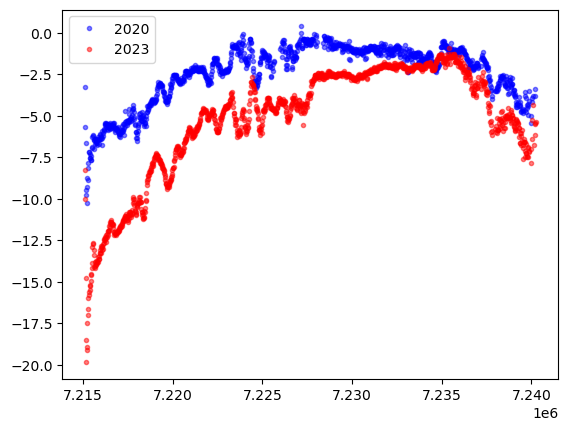

In [53]:
gt = 50
idx1 = gdf1['gt'] == gt
idx2 = gdf2['gt'] == gt

pt1 = gdf1.loc[idx1].sort_values('x_atc')
pt2 = gdf2.loc[idx2].sort_values('x_atc')

pt1 = gdf1.loc[idx1].sort_values('x_atc')
pt2 = gdf2.loc[idx2].sort_values('x_atc')
# plt.scatter(gdf1.loc[idx1, 'x_atc'], gdf1.loc[idx1, 'y_atc'], c = "b", s = 10, label = "Nov 2020")
# plt.scatter(gdf2.loc[idx2, 'x_atc'], gdf2.loc[idx2, 'y_atc'], c = "r", s = 10, label = "Nov 2023")
plt.plot(pt1['x_atc'], pt1['h_diff'], '.', c = "b", alpha = 0.5, label = "2020")
plt.plot(pt2['x_atc'], pt2['h_diff'], '.', c = "r", alpha = 0.5, label = "2023")
plt.legend()

1425 1425 nan


(-12.0, 3.0)

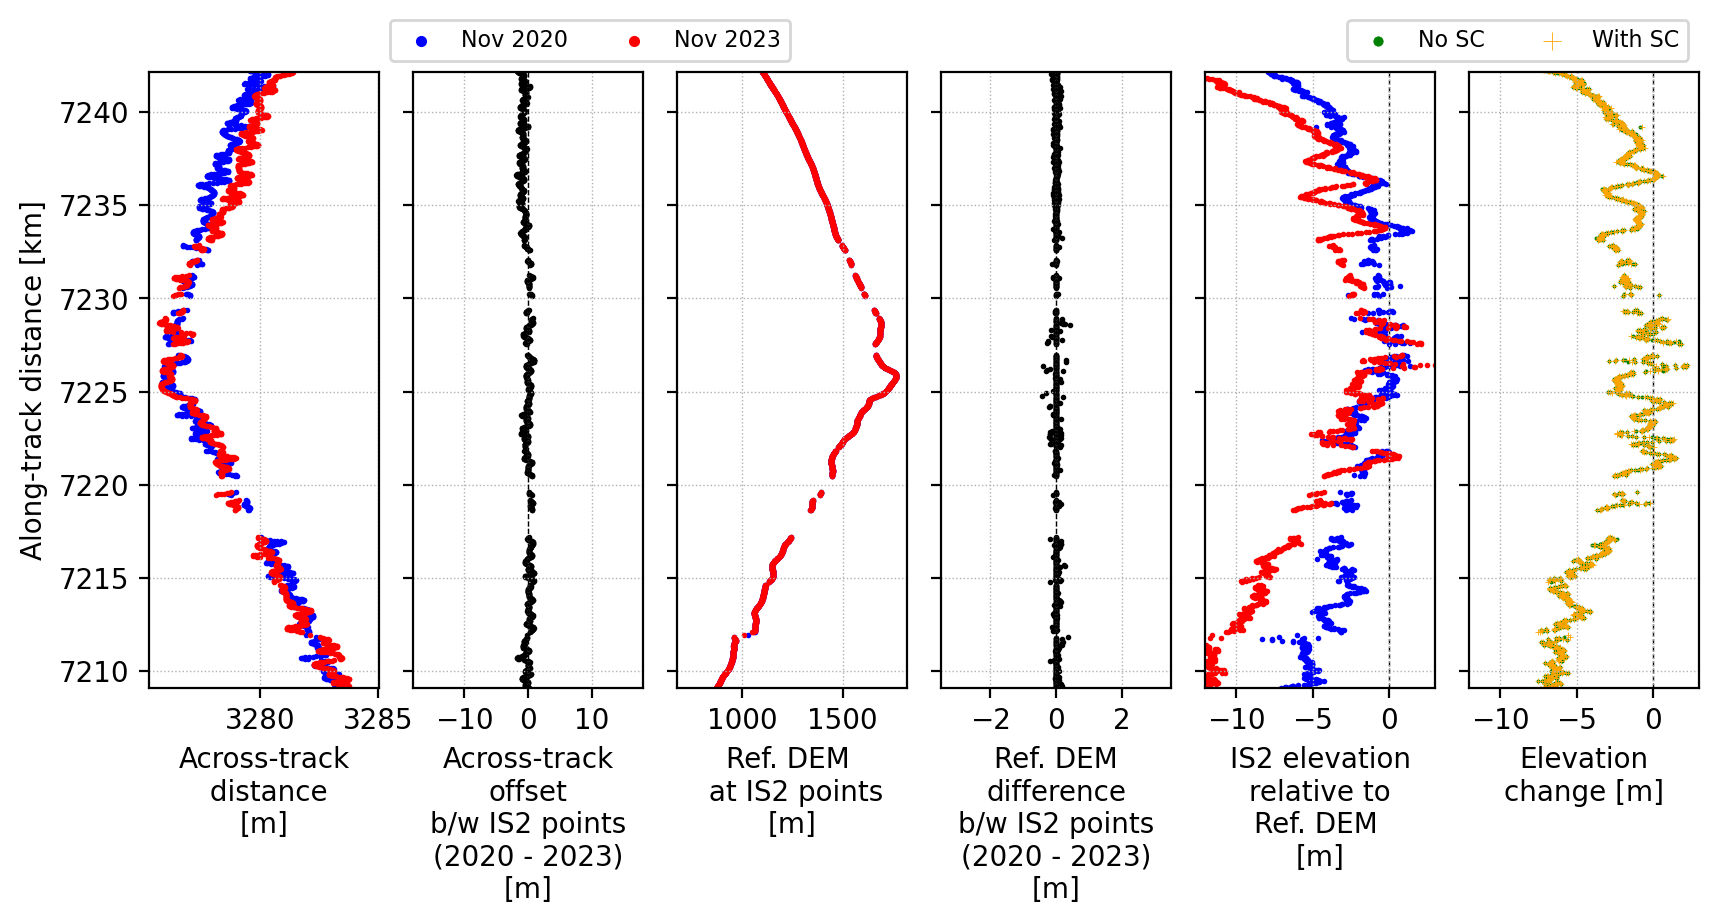

In [53]:
fig, ax = plt.subplots(1,6, figsize = (10, 4), dpi = 200, sharey = True)
fig.subplots_adjust(wspace = 0.15, hspace = 0.15)

gt = 10
idx1 = gdf1['gt'] == gt
idx2 = gdf2['gt'] == gt

pt1 = gdf1.loc[idx1].sort_values('x_atc')
pt2 = gdf2.loc[idx2].sort_values('x_atc')
pt1['x_atc'] = (pt1['x_atc']) * 0.001
pt2['x_atc'] = (pt2['x_atc']) * 0.001
pt0 = interpolate_track(pt1, pt2, yatc_th = 20, ref_field = "ref_dem") #.dropna()

ax[0].scatter(pt0['y_atc1'], pt0['x_atc'], c = "b", s = 1, label = "Nov 2020")
ax[0].scatter(pt0['y_atc2'], pt0['x_atc'], c = "r", s = 1, label = "Nov 2023")
# ax[0].plot(pt0['y_atc1'], pt0['x_atc'], c = "b", alpha = 0.5)
# ax[0].plot(pt0['y_atc2'], pt0['x_atc'], c = "r", alpha = 0.5)
# plt.axis('equal')
xmin, xmax = pt0['x_atc'].min() + 1, pt0['x_atc'].max()-1 # gdf1.loc[idx1, 'x'].median() - 100, gdf1.loc[idx1, 'x'].median() + 100
ymin, ymax = pt0['y_atc'].min() + 1, pt0['y_atc'].max()-1 # gdf1.loc[idx1, 'y'].median() - 400, gdf1.loc[idx1, 'y'].median() + 400
ax[0].set_ylim(xmin, xmax)
# ax[0].ylim(ymin, ymax)
# plt.plot([xmin-120, xmin-70], [ymin+20, ymin+20], color = "k")
# plt.text(xmin-120, ymin+30, "50 m", color = "k")
ax[0].legend(bbox_to_anchor = (1,1), loc = "lower left", ncol = 2, fontsize = 8, markerscale=3.)
ax[0].grid(ls = ":", lw = 0.5)
ax[0].set_ylabel("Along-track distance [km]")
ax[0].set_xlabel("Across-track\n distance\n[m]")

ax[1].scatter(pt0['y_atc1'] - pt0['y_atc2'], pt0['x_atc'], s = 1, c = "k")
# ax[1].plot(pt2['y_atc'], pt2['x_atc'], c = "r", alpha = 0.5)
ax[1].grid(ls = ":", lw = 0.5)
ax[1].set_xlabel("Across-track\noffset\nb/w IS2 points\n(2020 - 2023)\n[m]")
# ax[1].set_ylabel("Y coordinates (m)")
ax[1].set_xlim(-18, 18)
ax[1].axvline(color = "k", ls = "--", lw = 0.5)

# ax[2].plot(pt0['dem1'], pt0['x_atc'], ls = "-", lw = 1, c = "b")
# ax[2].plot(pt0['dem2'], pt0['x_atc'], ls = "-", lw = 1, c = "r")
ax[2].scatter(pt0['dem1'], pt0['x_atc'], s = 1, c = "b")
ax[2].scatter(pt0['dem2'], pt0['x_atc'], s = 1, c = "r")
ax[2].grid(ls = ":", lw = 0.5)
ax[2].set_xlabel("Ref. DEM \n at IS2 points\n[m]")
# ax[1].set_ylabel("Y coordinates (m)")

dd = pt0['dem1'] - pt0['dem2']
# dd[dd == 0] = np.nan
ax[3].scatter(dd, pt0['x_atc'], s = 1, c = "k")
# ax[1].plot(pt2['y_atc'], pt2['x_atc'], c = "r", alpha = 0.5)
ax[3].grid(ls = ":", lw = 0.5)
ax[3].axvline(color = "k", ls = "--", lw = 0.5)
ax[3].set_xlabel("Ref. DEM\ndifference\nb/w IS2 points\n(2020 - 2023)\n[m]")
ax[3].set_xlim(-3.5, 3.5)
ax[3].set_xticks([-2, 0, 2])
# ax[1].set_ylabel("Y coordinates (m)")

ax[4].scatter(pt0['h_mean1'], pt0['x_atc'], s= 1, c = "b")
ax[4].scatter(pt0['h_mean2'], pt0['x_atc'], s=1, c = "r")
ax[4].grid(ls = ":", lw = 0.5)
ax[4].set_xlabel("IS2 elevation\nrelative to\nRef. DEM \n[m]")
ax[4].axvline(color = "k", ls = "--", lw = 0.5, zorder = 0)
ax[4].set_xlim(-12, 3)
ax[4].set_xticks([-10, -5, 0])
# ax[1].set_ylabel("Y coordinates (m)")

ax[5].scatter(pt0['diff_is2'] - (pt0['dem1'] - pt0['dem2']), pt0['x_atc'], s = 5, lw = 0.3, fc = "g", marker = ".", label = "No SC")
ax[5].scatter(pt0['diff_is2'], pt0['x_atc'], s = 5, lw = 0.3, fc = "orange", marker = "+", label = "With SC")
ax[5].legend(bbox_to_anchor = (1,1), loc = "lower right", ncol = 2, fontsize = 8, markerscale=3.)
# ax[5].plot(pt0['h_mean2'] - pt0['dem1'], pt0['x_atc'], ls = "--", c = "r")
ax[5].grid(ls = ":", lw = 0.5)
ax[5].set_xlabel("Elevation\nchange [m]")
ax[5].axvline(color = "k", ls = "--", lw = 0.5, zorder = 0)
ax[5].set_xticks([-10, -5, 0])
ax[5].set_xlim(-12, 3)

1181 1181 nan


(-12.0, 3.0)

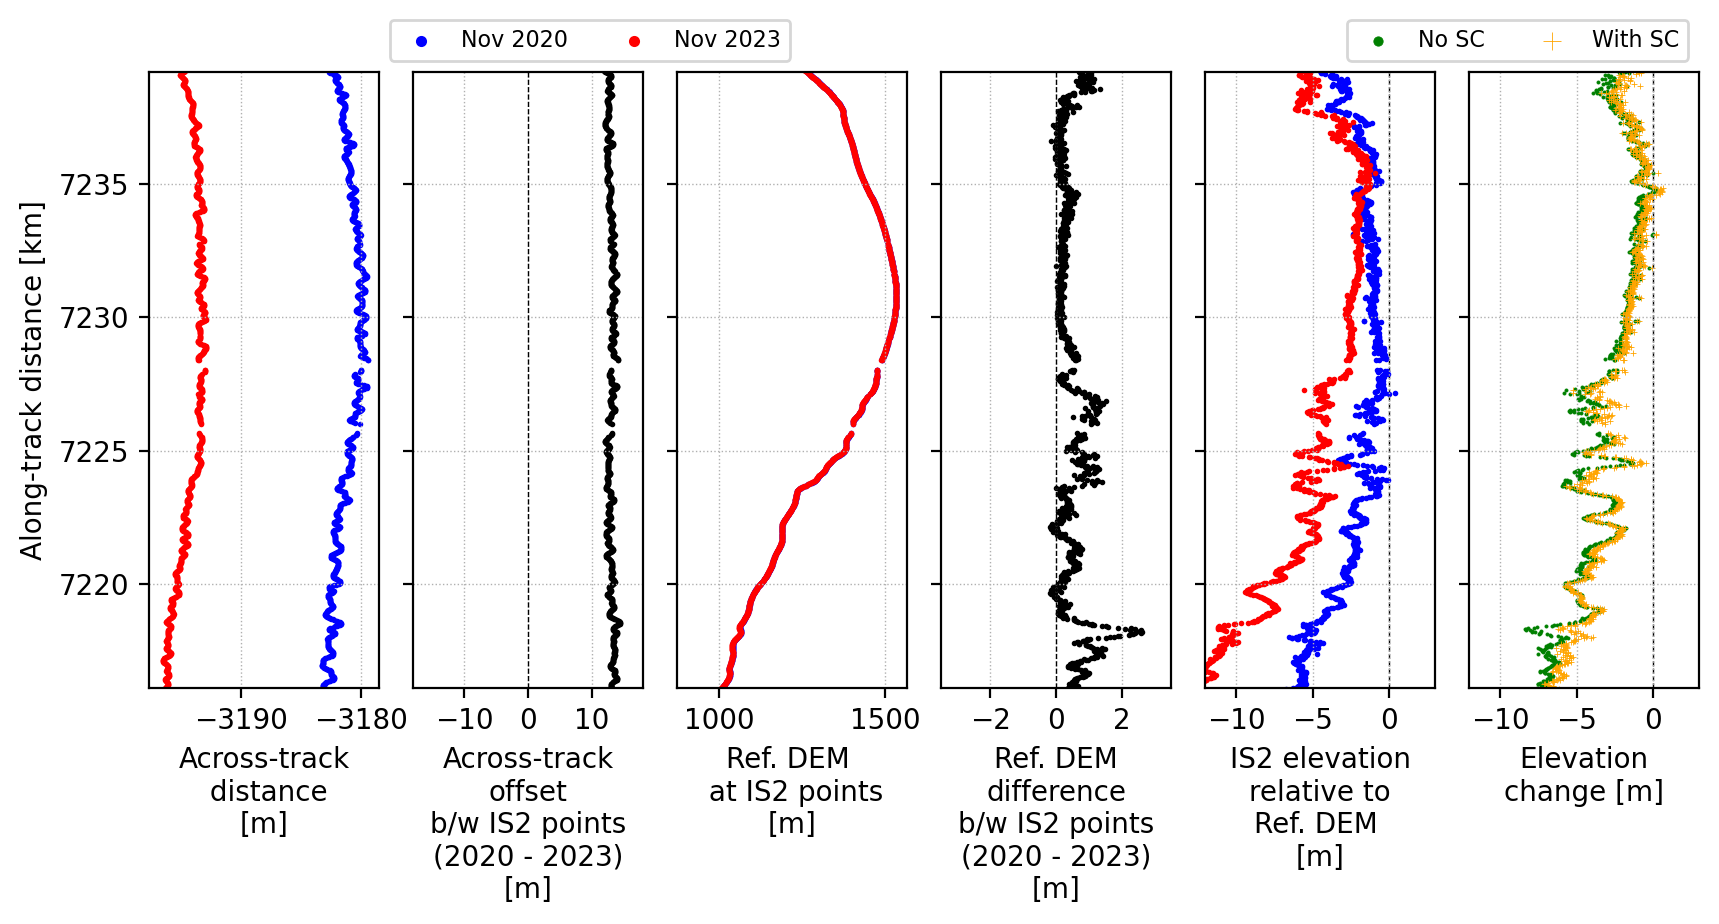

In [54]:
fig, ax = plt.subplots(1,6, figsize = (10, 4), dpi = 200, sharey = True)
fig.subplots_adjust(wspace = 0.15, hspace = 0.15)

gt = 50
idx1 = gdf1['gt'] == gt
idx2 = gdf2['gt'] == gt

pt1 = gdf1.loc[idx1].sort_values('x_atc')
pt2 = gdf2.loc[idx2].sort_values('x_atc')
pt1['x_atc'] = (pt1['x_atc']) * 0.001
pt2['x_atc'] = (pt2['x_atc']) * 0.001
pt0 = interpolate_track(pt1, pt2, yatc_th = 20, ref_field = "ref_dem") #.dropna()

ax[0].scatter(pt0['y_atc1'], pt0['x_atc'], c = "b", s = 1, label = "Nov 2020")
ax[0].scatter(pt0['y_atc2'], pt0['x_atc'], c = "r", s = 1, label = "Nov 2023")
# ax[0].plot(pt0['y_atc1'], pt0['x_atc'], c = "b", alpha = 0.5)
# ax[0].plot(pt0['y_atc2'], pt0['x_atc'], c = "r", alpha = 0.5)
# plt.axis('equal')
xmin, xmax = pt0['x_atc'].min() + 1, pt0['x_atc'].max()-1 # gdf1.loc[idx1, 'x'].median() - 100, gdf1.loc[idx1, 'x'].median() + 100
ymin, ymax = pt0['y_atc'].min() + 1, pt0['y_atc'].max()-1 # gdf1.loc[idx1, 'y'].median() - 400, gdf1.loc[idx1, 'y'].median() + 400
ax[0].set_ylim(xmin, xmax)
# ax[0].ylim(ymin, ymax)
# plt.plot([xmin-120, xmin-70], [ymin+20, ymin+20], color = "k")
# plt.text(xmin-120, ymin+30, "50 m", color = "k")
ax[0].legend(bbox_to_anchor = (1,1), loc = "lower left", ncol = 2, fontsize = 8, markerscale=3.)
ax[0].grid(ls = ":", lw = 0.5)
ax[0].set_ylabel("Along-track distance [km]")
ax[0].set_xlabel("Across-track\n distance\n[m]")

ax[1].scatter(pt0['y_atc1'] - pt0['y_atc2'], pt0['x_atc'], s = 1, c = "k")
# ax[1].plot(pt2['y_atc'], pt2['x_atc'], c = "r", alpha = 0.5)
ax[1].grid(ls = ":", lw = 0.5)
ax[1].set_xlabel("Across-track\noffset\nb/w IS2 points\n(2020 - 2023)\n[m]")
# ax[1].set_ylabel("Y coordinates (m)")
ax[1].set_xlim(-18, 18)
ax[1].axvline(color = "k", ls = "--", lw = 0.5)

# ax[2].plot(pt0['dem1'], pt0['x_atc'], ls = "-", lw = 1, c = "b")
# ax[2].plot(pt0['dem2'], pt0['x_atc'], ls = "-", lw = 1, c = "r")
ax[2].scatter(pt0['dem1'], pt0['x_atc'], s = 1, c = "b")
ax[2].scatter(pt0['dem2'], pt0['x_atc'], s = 1, c = "r")
ax[2].grid(ls = ":", lw = 0.5)
ax[2].set_xlabel("Ref. DEM \n at IS2 points\n[m]")
# ax[1].set_ylabel("Y coordinates (m)")

dd = pt0['dem1'] - pt0['dem2']
# dd[dd == 0] = np.nan
ax[3].scatter(dd, pt0['x_atc'], s = 1, c = "k")
# ax[1].plot(pt2['y_atc'], pt2['x_atc'], c = "r", alpha = 0.5)
ax[3].grid(ls = ":", lw = 0.5)
ax[3].axvline(color = "k", ls = "--", lw = 0.5)
ax[3].set_xlabel("Ref. DEM\ndifference\nb/w IS2 points\n(2020 - 2023)\n[m]")
ax[3].set_xlim(-3.5, 3.5)
ax[3].set_xticks([-2, 0, 2])
# ax[1].set_ylabel("Y coordinates (m)")

ax[4].scatter(pt0['h_mean1'], pt0['x_atc'], s= 1, c = "b")
ax[4].scatter(pt0['h_mean2'], pt0['x_atc'], s=1, c = "r")
ax[4].grid(ls = ":", lw = 0.5)
ax[4].set_xlabel("IS2 elevation\nrelative to\nRef. DEM \n[m]")
ax[4].axvline(color = "k", ls = "--", lw = 0.5, zorder = 0)
ax[4].set_xlim(-12, 3)
ax[4].set_xticks([-10, -5, 0])
# ax[1].set_ylabel("Y coordinates (m)")

ax[5].scatter(pt0['diff_is2'] - (pt0['dem1'] - pt0['dem2']), pt0['x_atc'], s = 5, lw = 0.3, fc = "g", marker = ".", label = "No SC")
ax[5].scatter(pt0['diff_is2'], pt0['x_atc'], s = 5, lw = 0.3, fc = "orange", marker = "+", label = "With SC")
ax[5].legend(bbox_to_anchor = (1,1), loc = "lower right", ncol = 2, fontsize = 8, markerscale=3.)
# ax[5].plot(pt0['h_mean2'] - pt0['dem1'], pt0['x_atc'], ls = "--", c = "r")
ax[5].grid(ls = ":", lw = 0.5)
ax[5].set_xlabel("Elevation\nchange [m]")
ax[5].axvline(color = "k", ls = "--", lw = 0.5, zorder = 0)
ax[5].set_xticks([-10, -5, 0])
ax[5].set_xlim(-12, 3)

Text(0.5, 0, 'ICESat-2 - DEM height (m)')

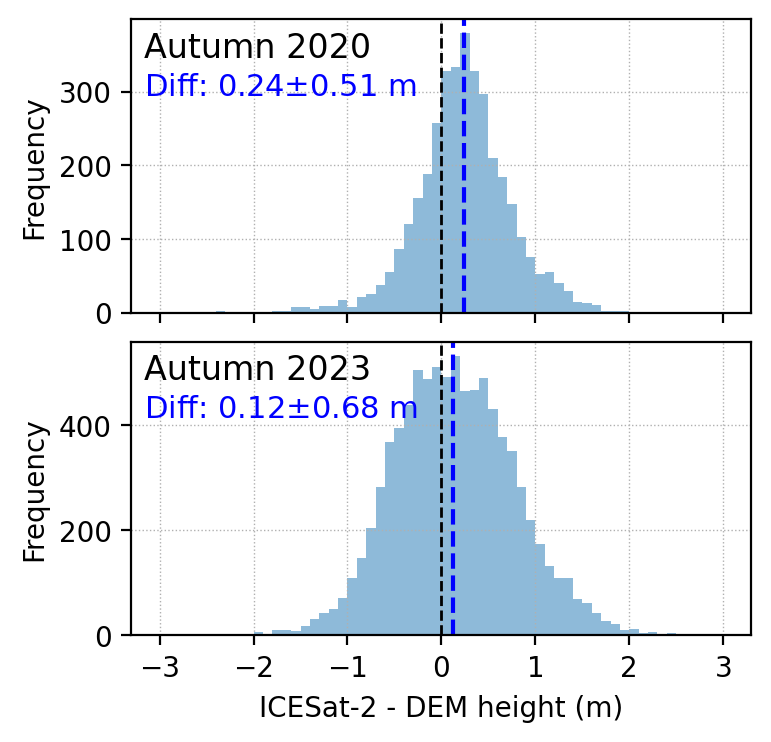

In [77]:
fig, ax = plt.subplots(2, 1, figsize = (4,4), dpi = 200, sharex = True)
fig.subplots_adjust(wspace = 0.05, hspace = 0.1)

ax[0].hist(gdf1['h_diff_dem'], range = (-3, 3), bins = 60, alpha = 0.5);
ax[0].axvline(gdf1['h_diff_dem'].median(), color = "b", ls = "--")
ax[0].axvline(0, color = "k", ls = "--", lw = 1)
ax[0].grid(ls = ":", lw = 0.5, zorder = 0)
ax[0].set_ylabel("Frequency")
ax[0].annotate(f"Autumn 2020", xy=(0.02, 0.96), xycoords='axes fraction', fontsize=12, ha='left', va='top', color = "k")
ax[0].annotate(f"Diff: {gdf1['h_diff_dem'].median():.2f}$\pm${gdf1['h_diff_dem'].std():.2f} m", xy=(0.02, 0.82), xycoords='axes fraction', fontsize=11, ha='left', va='top', color = "b")

ax[1].hist(gdf2['h_diff_dem'], range = (-3, 3), bins = 60, alpha = 0.5);
ax[1].axvline(gdf2['h_diff_dem'].median(), color = "b", ls = "--")
ax[1].axvline(0, color = "k", ls = "--", lw = 1)
ax[1].grid(ls = ":", lw = 0.5, zorder = 0)
ax[1].set_ylabel("Frequency")
ax[1].annotate(f"Autumn 2023", xy=(0.02, 0.96), xycoords='axes fraction', fontsize=12, ha='left', va='top', color = "k")
ax[1].annotate(f"Diff: {gdf2['h_diff_dem'].median():.2f}$\pm${gdf2['h_diff_dem'].std():.2f} m", xy=(0.02, 0.82), xycoords='axes fraction', fontsize=11, ha='left', va='top', color = "b")

ax[1].set_xlabel("ICESat-2 - DEM height (m)")

Text(0.02, 0.82, '(N=3644)')

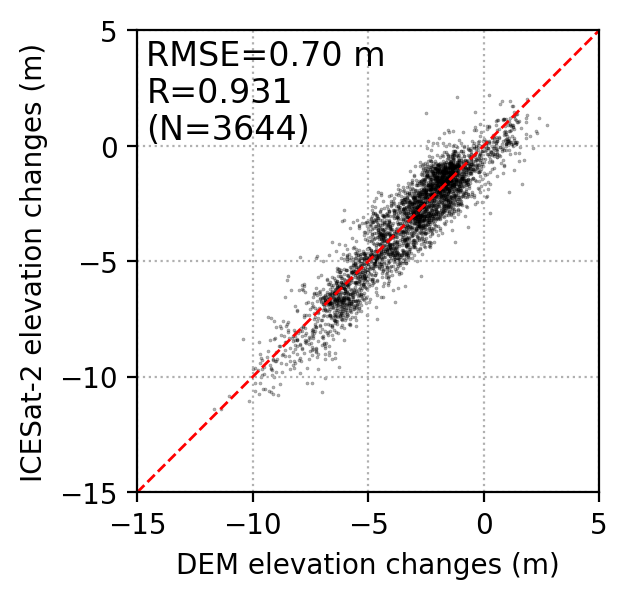

In [27]:
xval = gdf1['diff_dem'] #gdf1['dem_diff_org']
yval = gdf1['diff_is2']
idx = (abs(xval) > 0) & (abs(yval) > 0)

fig, ax = plt.subplots(1,1, figsize = (3,3), dpi = 200)
rmse = np.nanmean(np.square(xval[idx]-yval[idx]) ** 0.5)
r = np.corrcoef(xval[idx], yval[idx])[0][1]

# cbar = plt.hist2d(xval[idx], yval[idx], bins = 200, vmax = 10, cmap = "binary")
plt.scatter(xval, yval, c = "k", s= 5, marker = ".", lw = 0.2, alpha = 0.3)

plt.axis('scaled')
# plt.axhline(0, color = "k", ls = "--", lw = 0.5)
# plt.axvline(0, color = "k", ls = "--", lw = 0.5)
ranges = [-15, 5]
plt.plot(ranges, ranges, color = "r", ls = "--", lw = 1)
plt.yticks(np.arange(-15, 10, 5))
plt.grid(ls = ":")
plt.xlim(ranges)
plt.ylim(ranges)

plt.xlabel("DEM elevation changes (m)", fontsize = 10)
plt.ylabel("ICESat-2 elevation changes (m)", fontsize = 10)

plt.annotate(f"RMSE={rmse:.2f} m", xy=(0.02,0.98), xycoords='axes fraction', fontsize=12, ha='left', va='top', color = "k")
plt.annotate(f"R={r:.3f}", xy=(0.02,0.90), xycoords='axes fraction', fontsize=12, ha='left', va='top', color = "k")
plt.annotate(f"(N={len(xval[idx])})", xy=(0.02,0.82), xycoords='axes fraction', fontsize=12, ha='left', va='top', color = "k")
# fig.colorbar(cbar[3], label = "dh dyn", shrink = 0.6)
# fig.colorbar(cbar[3], ax=ax, shrink = 0.6, label = "Frequency", extend = "max")

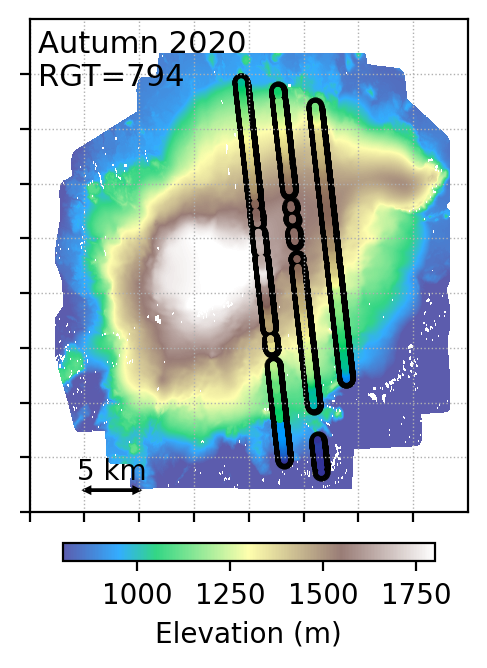

In [38]:
fig, ax = plt.subplots(1,1,figsize = (4,4), dpi = 200)

gdf1.plot(c = "k", ax = ax, markersize = 30, alpha = 0.8)
gdf1.plot("h_mean", ax = ax, vmin = 800, vmax = 1800, cmap = "terrain", markersize = 2)

# from matplotlib import pyplot
from rasterio.plot import show
# src = rasterio.open("G:/My Drive/iceland_oct2020_50.tif")
src = rasterio.open("G:\\My Drive\\Colab Notebooks\\Iceland\\Data_glacier\\hofs_oct2020_jitcor_mosaicblend.tif")
cbar = show(src, cmap = "terrain", ax = ax, alpha = 0.8, vmin = 800, vmax = 1800)

# ax.legend()
plt.axis('scaled')
# ax.title(f"{y} {season.upper()}")

x1, x2 = ax.set_xlim(488000, 528000)
y1, y2 = ax.set_ylim(457000, 502000)
ax.set_yticks(np.arange(y1, y2, 5000), [])
ax.set_xticks(np.arange(x1, x2, 5000), [])
ax.grid(ls = ":", lw = 0.5)

plt.annotate(f"Autumn 2020\nRGT={rgt}", xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top', color = "k")

im = cbar.get_images()[0]
fig.colorbar(im, shrink = 0.6, label = "Elevation (m)", orientation = 'horizontal', pad = 0.05)

# SCale bar
plt.annotate("5 km", xy=(488000 + 7500, 457000+3000), fontsize = 10, ha = "center")
ax.arrow(488000 + 5000, 457000+2000, 5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)
ax.arrow(488000 + 10000, 457000+2000, -5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)

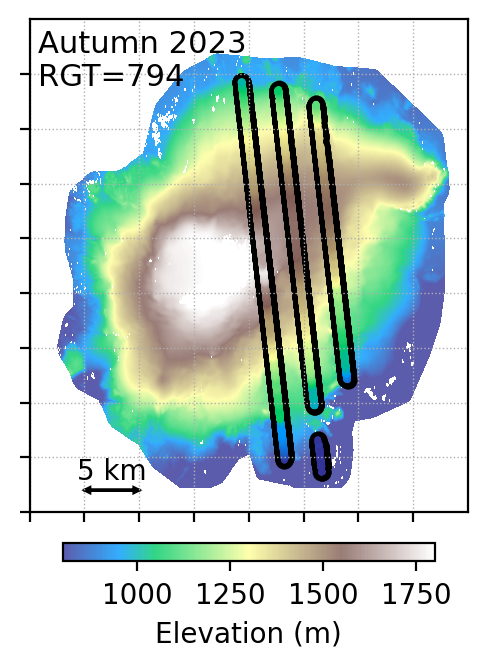

In [37]:
fig, ax = plt.subplots(1,1,figsize = (4,4), dpi = 200)

gdf2.plot(c = "k", ax = ax, markersize = 30, alpha = 0.8)
gdf2.plot("h_mean", ax = ax, vmin = 800, vmax = 1800, cmap = "terrain", markersize = 2)

# from matplotlib import pyplot
# src = rasterio.open("G:/My Drive/iceland_oct2023_50.tif")
src = rasterio.open("G:\\My Drive\\Colab Notebooks\\Iceland\\Data_glacier\\hofs_sep2023_jitcor_mosaicblend.tif")
cbar = show(src, cmap = "terrain", ax = ax, alpha = 0.8, vmin = 800, vmax = 1800)

# ax.legend()
plt.axis('scaled')
# ax.title(f"{y} {season.upper()}")

x1, x2 = ax.set_xlim(488000, 528000)
y1, y2 = ax.set_ylim(457000, 502000)
ax.set_yticks(np.arange(y1, y2, 5000), [])
ax.set_xticks(np.arange(x1, x2, 5000), [])
ax.grid(ls = ":", lw = 0.5)

plt.annotate(f"Autumn 2023\nRGT={rgt}", xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top', color = "k")

im = cbar.get_images()[0]
fig.colorbar(im, shrink = 0.6, label = "Elevation (m)", orientation = 'horizontal', pad = 0.05)

# SCale bar
plt.annotate("5 km", xy=(488000 + 7500, 457000+3000), fontsize = 10, ha = "center")
ax.arrow(488000 + 5000, 457000+2000, 5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)
ax.arrow(488000 + 10000, 457000+2000, -5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)

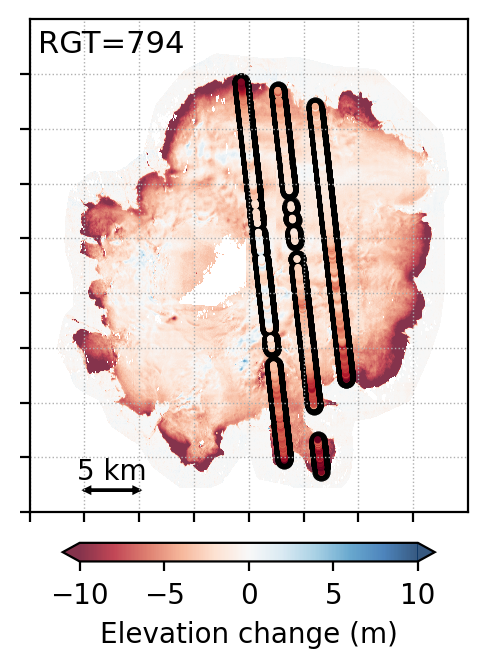

In [39]:
fig, ax = plt.subplots(1,1,figsize = (4,4), dpi = 200)

gdf1.plot(c = "k", ax = ax, markersize = 30, alpha = 0.8)
gdf1.plot("diff_is2", ax = ax, vmin = -10, vmax = 10, cmap = "RdBu", markersize = 2)

# from matplotlib import pyplot
# src = rasterio.open("G:/My Drive/iceland_diff_50.tif")
src = rasterio.open("G:\\My Drive\\Colab Notebooks\\Iceland\\Data_glacier\\hofs_sep2023_jitcor_mosaicblend__hofs_oct2020_jitcor_mosaicblend-diff.tif")
cbar = show(src, cmap = "RdBu", vmin = -10, vmax = 10, ax = ax, alpha = 0.8)

# ax.legend()
plt.axis('scaled')
# ax.title(f"{y} {season.upper()}")

x1, x2 = ax.set_xlim(488000, 528000)
y1, y2 = ax.set_ylim(457000, 502000)
ax.set_yticks(np.arange(y1, y2, 5000), [])
ax.set_xticks(np.arange(x1, x2, 5000), [])
ax.grid(ls = ":", lw = 0.5)

plt.annotate(f"RGT={rgt}", xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top', color = "k")

im = cbar.get_images()[0]
fig.colorbar(im, shrink = 0.6, label = "Elevation change (m)", orientation = 'horizontal', pad = 0.05, extend = "both")

# SCale bar
plt.annotate("5 km", xy=(488000 + 7500, 457000+3000), fontsize = 10, ha = "center")
ax.arrow(488000 + 5000, 457000+2000, 5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)
ax.arrow(488000 + 10000, 457000+2000, -5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)

# Galcier volume change

In [5]:
from datetime import datetime
from scipy.interpolate import RegularGridInterpolator
import geoutils as gu
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import xdem

shapefile = gpd.read_file("G:/My Drive/Colab Notebooks/Iceland/outline/hofsj_2023.shp").to_crs(3057)

res = 100
spacing = res
xp = np.arange(490000, 530000, spacing)
yp = np.arange(460000, 500000, spacing)

x_len = len(xp)
y_len = len(yp)

xp, yp = np.meshgrid(xp, yp)

with rasterio.open(f"G:/My Drive/iceland_oct2020_20_jitcor.tif") as src: #rasterio.open(f"G:/My Drive/iceland_oct2020_50.tif") as src:
    band1 = src.read(1)
    # band1[band1 < 1100] = np.nan

    height = band1.shape[0]
    width = band1.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xxd, yyd = rasterio.transform.xy(src.transform, rows, cols)
    xxd = np.array(xxd).reshape(band1.shape)
    yyd = np.array(yyd).reshape(band1.shape)

    print('Band1 has shape', band1.shape)

ref_dem = xp.copy() * 0.

from scipy import interpolate

f = RegularGridInterpolator((yyd[:, 0], xxd[0]), band1, bounds_error=False, fill_value=None)
ref_dem = f((yp, xp))

# for i in tqdm(range(0, xp.shape[0])):
#   for j in range(0, xp.shape[1]):
#     row, col = np.where((abs(xxd-xp[i,j]) < spacing) & ((abs(yyd-yp[i,j]) < spacing)))
#     ref_dem[i,j] = np.nanmean(band1[row, col])

ref_dem = xdem.DEM.from_array(ref_dem, (spacing, 0.0, xp[0, 0], 0.0, spacing, yp[0, 0]), 3057)

glaciers = gu.Vector(shapefile)
print("DONE!")

Band1 has shape (2180, 2059)
DONE!


In [6]:
version = "Arctic2m"
with open(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_dh_2023-2020_100_slopecor_{version}.pkl", 'rb') as file:
  # A new file will be created
  [gdf_track, dh_sum, h_sum, seasons] = pickle.load(file)

gdf_combine = gpd.GeoDataFrame()
for gdf in gdf_track:
  gdf_combine = pd.concat([gdf_combine, gdf]).reset_index(drop = True)

res = 100
# Track by track - WINTER
xp = np.arange(490000, 530000, res)
yp = np.arange(460000, 500000, res)
xp, yp = np.meshgrid(xp, yp)

xx, yy = xp, yp; #np.meshgrid(np.arange(490000., 530000., 500), np.arange(460000., 500000., 500))

df_grid = pd.DataFrame({'x': xx.flatten(), 'y': yy.flatten(), 'flag': yy.flatten()*0})
gdf_grid = gpd.GeoDataFrame(df_grid, geometry=gpd.points_from_xy(df_grid.x, df_grid.y), crs="EPSG:3057")

dd = gpd.sjoin(left_df=gdf_grid, right_df=shapefile, how='inner')
df_grid.loc[dd.index, 'flag'] = 1
# Glacier flag
flag = df_grid['flag'].values.reshape(xx.shape[0], xx.shape[1])
flag = flag.astype(float)

dh_dem0 = np.zeros(xx.shape)

# from matplotlib import pyplot
file = f"G:/My Drive/iceland_diff_20_jitcor.tif"
# file = "G:\\My Drive\\Colab Notebooks\\Iceland\\Data_glacier\\hofs_sep2023_jitcor_mosaicblend__hofs_oct2020_jitcor_mosaicblend-diff.tif"
with rasterio.open(file) as src:
    band_diff = src.read(1)
    # band_diff[band_diff < 0] = np.nan
    # band1[band1 < 1100] = np.nan

    height = band_diff.shape[0]
    width = band_diff.shape[1]
    
    idx_nan = np.where(np.isnan(band_diff))
    print("DEM data processing ...")
    for i in tqdm(range(0, len(idx_nan[0]))):
        band_diff[idx_nan[0][i], idx_nan[1][i]] = np.nanmedian(band_diff[max(0,idx_nan[0][i]-2):min(idx_nan[0][i]+3, height),
                                                             max(0,idx_nan[1][i]-2):min(idx_nan[1][i]+3, width)])

    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xxd, yyd = rasterio.transform.xy(src.transform, rows, cols)
    xxd = np.array(xxd).reshape(band_diff.shape)
    yyd = np.array(yyd).reshape(band_diff.shape)

f = RegularGridInterpolator((yyd[:, 0], xxd[0]), band_diff, bounds_error=False, fill_value=None)
dh_dem0 = f((yp, xp))
# dh_dem0[dh_dem0 < ]

# from matplotlib import pyplot
file = f"G:/My Drive/iceland_oct2020_20_jitcor.tif"
with rasterio.open(file) as src:
    band1 = src.read(1)
    height = band1.shape[0]
    width = band1.shape[1]

    idx_nan = np.where(np.isnan(band1))
    print("DEM data processing ...")
    for i in tqdm(range(0, len(idx_nan[0]))):
      band1[idx_nan[0][i], idx_nan[1][i]] = np.nanmedian(band1[max(0,idx_nan[0][i]-2):min(idx_nan[0][i]+3, height),
                                                             max(0,idx_nan[1][i]-2):min(idx_nan[1][i]+3, width)])


    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xxd, yyd = rasterio.transform.xy(src.transform, rows, cols)
    xxd = np.array(xxd).reshape(band1.shape)
    yyd = np.array(yyd).reshape(band1.shape)

f = RegularGridInterpolator((yyd[:, 0], xxd[0]), band1, bounds_error=False)
ref_dem = f((yp, xp))
ref_dem[np.isnan(ref_dem)] = np.nanmin(ref_dem)
ref_dem = xdem.DEM.from_array(ref_dem, (res, 0.0, xp[0, 0], 0.0, res, yp[0, 0]), 3057)

dh_dem0[(dh_dem0 > 10) | ((abs(dh_dem0) > 10) & (ref_dem.data > 1600))] = np.nan

print('dh DEM has shape', dh_dem0.shape)
print('Reference DEM has shape', ref_dem.shape)

DEM data processing ...


100%|█████████████████████████████████████████████████████████████████████| 1752590/1752590 [01:15<00:00, 23355.32it/s]


DEM data processing ...


100%|█████████████████████████████████████████████████████████████████████| 1334761/1334761 [00:56<00:00, 23633.43it/s]


dh DEM has shape (400, 400)
Reference DEM has shape (400, 400)


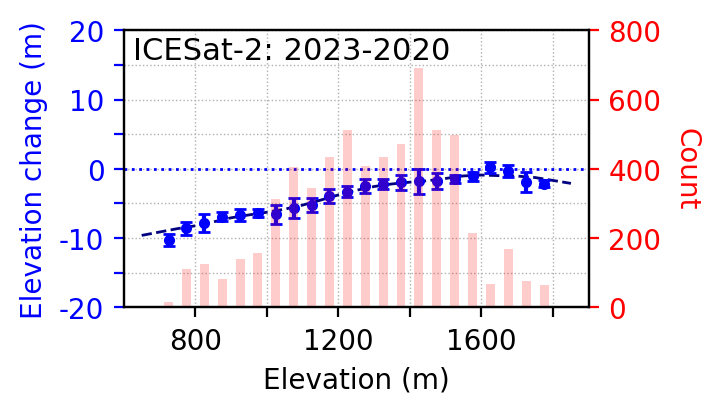

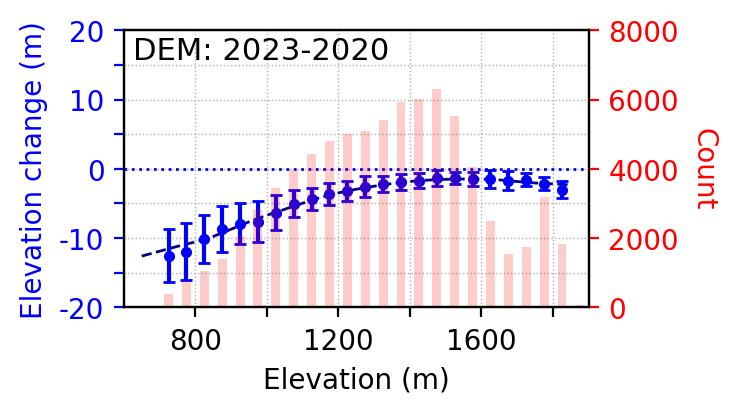

In [14]:
# 2023-2020
xx, yy = xp, yp;
krg_sum = np.zeros([xx.shape[0], xx.shape[1]])
krg_sum_s2 = np.zeros([xx.shape[0], xx.shape[1]])

k = 3
dh_is2 = np.nanmean(dh_sum[k:k+1], axis = 0)
h_is2 = np.nanmean(h_sum[k:k+1], axis = 0)
ref_dem_is2 = xdem.DEM.from_array(h_is2, (res, 0.0, xp[0, 0], 0.0, res, yp[0, 0]), 3057)
dh_dem = xdem.DEM.from_array(dh_is2, (res, 0.0, xp[0, 0], 0.0, res, yp[0, 0]), 3057)
dh_dem = xdem.dDEM(raster = dh_dem, start_time=datetime(2020, 10, 1), end_time=datetime(2023, 10, 1))
# field = dh_dem.interpolate(method="regional_hypsometric", reference_elevation=ref_dem, mask = glaciers)

mask = glaciers.create_mask(ref_dem)

# ddem_bins = xdem.volume.hypsometric_binning(dh_dem[mask], ref_dem_is2[mask])
# stds = xdem.volume.hypsometric_binning(dh_dem[mask], ref_dem[mask], aggregation_function=np.std)
# stds = stds.dropna().reset_index(drop = False)

# s2 = xp.copy() * 0 + 5
# H = ref_dem.data.data

# for i in range(0, len(stds)):
#   v0 = stds['index'][i].left
#   v1 = stds['index'][i].right
#   s2[(H >= v0) & (H < v1)] = stds['value'][i]**2

# field, s2 = hypsometric(dh_dem, ref_dem, mask) 

# Individual track ==========================
gdf2 = gdf_track[k]
gdf2 = gdf2[gdf2['rgt'] == 794].reset_index(drop = True)
gdf2['category'] = 1
idh, s2 = hypsometric_raw_average(ref_dem.data.data, mask.data.data, gdf2)
field = np.nanmean(idh, axis = (0,1,2))*6
s2 = np.nanmean(s2, axis = (0,1,2))*6

# dh_dem0[dh_dem0 < -20] = np.nan
dh_dem00 = xdem.DEM.from_array(dh_dem0, (res, 0.0, xp[0, 0], 0.0, res, yp[0, 0]), 3057)
dh_dem00 = xdem.dDEM(raster = dh_dem00, start_time=datetime(2020, 10, 1), end_time=datetime(2023, 10, 1))

mask = glaciers.create_mask(dh_dem00)
hyp_name = f"C:\\Users\\yoko2261\\OneDrive - UCB-O365\\Documents\\paper_submission\\Iceland_glacier\\Hypsometry_IS2_2023-2020"
draw_hypsometry_dem(dh_dem00[mask], ref_dem[mask], "ICESat-2: 2023-2020", hyp_name, gdf = gdf2)

hyp_name = f"C:\\Users\\yoko2261\\OneDrive - UCB-O365\\Documents\\paper_submission\\Iceland_glacier\\Hypsometry_DEM_2023-2020"
spl = draw_hypsometry_dem(dh_dem00[mask], ref_dem[mask], "DEM: 2023-2020", hyp_name, output = True)

spl_dh = spl(ref_dem.data)
dh_dem1 = np.where(np.isnan(dh_dem0), spl_dh, dh_dem0)
# dh_dem1 = xdem.DEM.from_array(dh_dem1, (res, 0.0, xp[0, 0], 0.0, res, yp[0, 0]), 3057)

ICESat-2 volume change:  -2.454890840155871
ICESat-2 uncertainty:  0.9410120242802242 0.9410120242802245 0.9410120242802246
DEM      volume change:  -2.616350056941688
Volume difference     :  0.1614592167858171
Volume difference (%) :  6.171162622426393
Done!


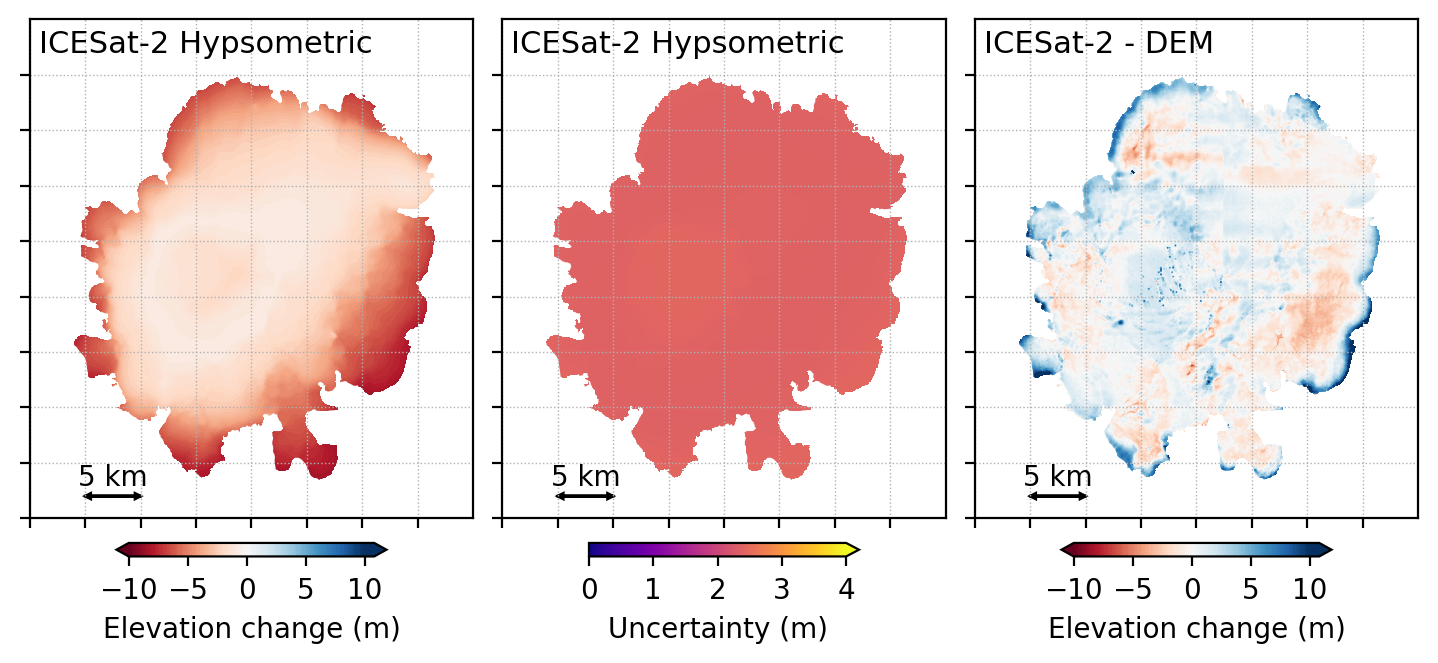

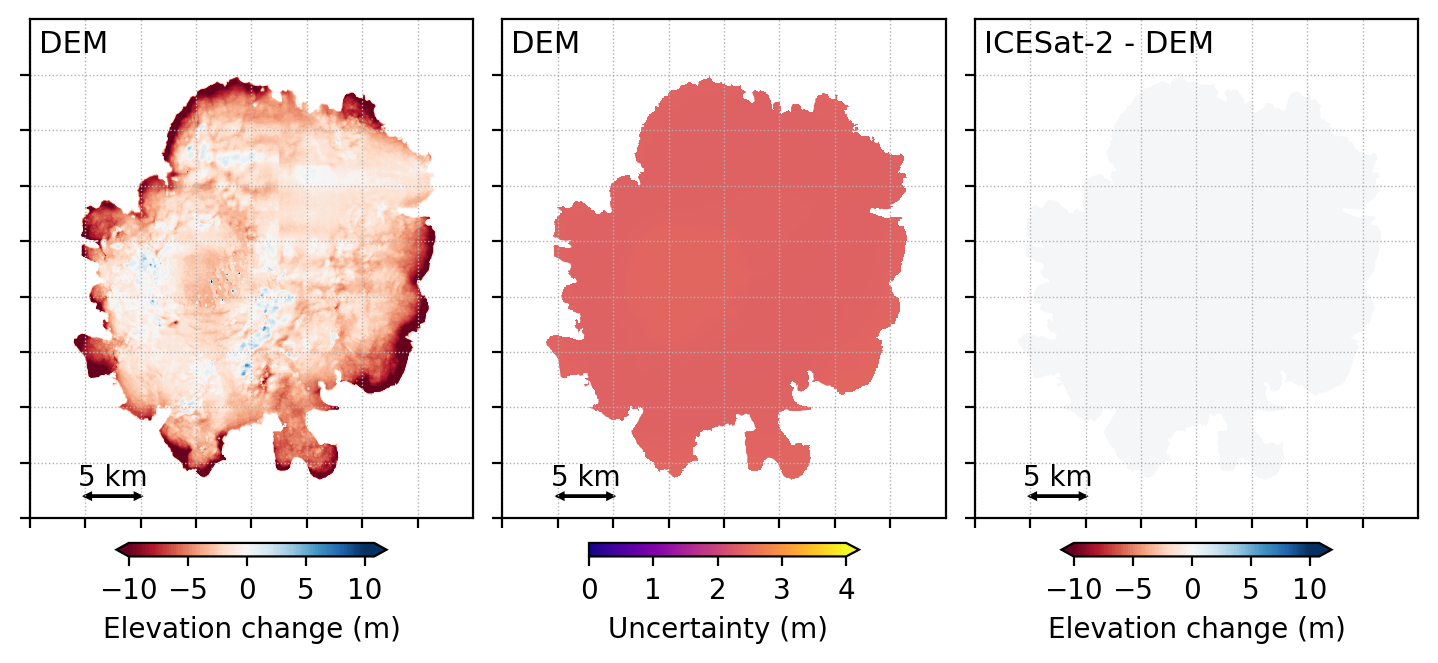

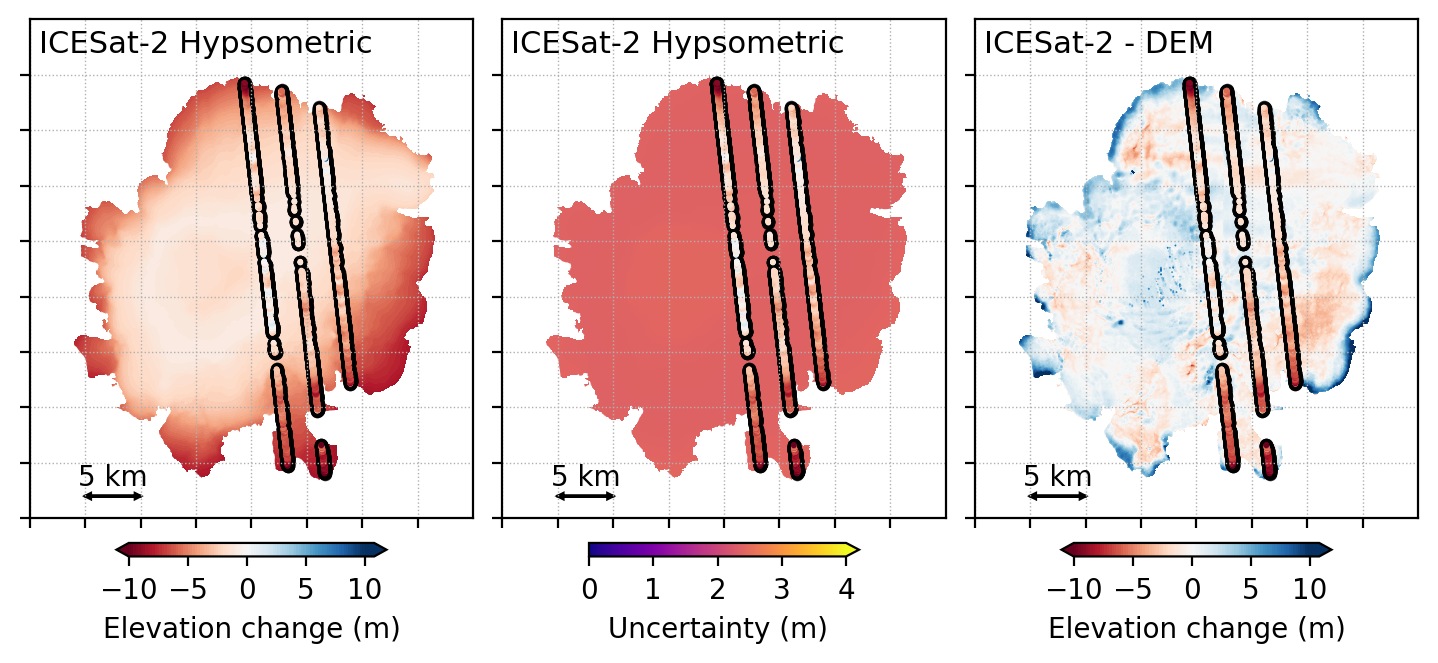

In [15]:
fig_name = f"C:\\Users\\yoko2261\\OneDrive - UCB-O365\\Documents\\paper_submission\\Iceland_glacier\\Map_DEM_2023-2020_without_track"
draw_dem(xx, yy, field, s2, outside, gdf2, "ICESat-2 Hypsometric", dh_dem1, draw_track = False, figname = fig_name)
fig_name = f"C:\\Users\\yoko2261\\OneDrive - UCB-O365\\Documents\\paper_submission\\Iceland_glacier\\Map_IS2_2023-2020_without_track"
draw_dem(xx, yy, dh_dem1, s2, outside, gdf2, "DEM", dh_dem1, draw_track = False, figname = fig_name)
fig_name = f"C:\\Users\\yoko2261\\OneDrive - UCB-O365\\Documents\\paper_submission\\Iceland_glacier\\Map_DEM_2023-2020_with_track"
draw_dem(xx, yy, field, s2, outside, gdf2, "ICESat-2 Hypsometric", dh_dem1, draw_track = True, figname = fig_name)
# fig_name = f"D:\\Iceland\\Figure\\Map_IS2_2023-2020_with_track"
# draw_plot(xx, yy, dh_dem0, s2, outside, gdf_sum[k], "DEM", dh_dem0, draw_track = True, figname = fig_name)

field[flag == 0] = np.nan
s2[flag == 0] = np.nan
dh_dem1[flag == 0] = np.nan
idx = np.isnan(dh_dem1)
field[idx] = np.nan
# dh_dem0[idx] = np.nan

dv = np.nansum(field) * res* res / 1e9
dv_min = np.nansum(field-s2/2) * res* res / 1e9
dv_max = np.nansum(field+s2/2) * res* res / 1e9
dv_dm = np.nansum(dh_dem1) * res* res / 1e9

print("ICESat-2 volume change: ", dv)
print("ICESat-2 uncertainty: ", dv-dv_min, dv_max-dv, np.nansum(s2/2)*res*res/1e9)
print("DEM      volume change: ", dv_dm)
print("Volume difference     : ", (dv-dv_dm))
print("Volume difference (%) : ", (dv-dv_dm)/abs(dv_dm) * 100)

print("Done!")

# Glacier-wide mass balance

In [19]:
files = glob.glob(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_rgt*.csv")
n_tracks = []
for f in files:
  n_track = str(int(f.split("_rgt")[1][:4]))
  if n_track not in n_tracks:
    n_tracks.append(n_track)

# tracks2 = gpd.GeoDataFrame()
# for n_track in n_tracks:
#   tracks0 = tracks[tracks['Name'] == n_track]
#   tracks2 = pd.concat([tracks2, tracks0])

#### Elevation change (2020-2023)

In [49]:
# Track by track - SUMMER
spacing = 100
res = 100

version = "Arctic2m"
files = glob.glob(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_rgt*.csv")
n_tracks = []
for f in files:
  n_track = str(int(f.split("_rgt")[1][:4]))
  if n_track not in n_tracks:
    n_tracks.append(n_track)

print(n_tracks)

xp = np.arange(490000, 530000, spacing)
yp = np.arange(460000, 500000, spacing)

x_len = len(xp)
y_len = len(yp)

xp, yp = np.meshgrid(xp, yp)

df_grid = pd.DataFrame({'x': xp.flatten(), 'y': yp.flatten()})
gdf_grid = gpd.GeoDataFrame(df_grid, geometry=gpd.points_from_xy(df_grid.x, df_grid.y), crs="EPSG:3057")

seasons = ["win", "spr", "sum", "aut"] #range(2019, 2025)
dh_sum = np.zeros([len(seasons), xp.shape[0], xp.shape[1]])
h_sum = np.zeros([len(seasons), xp.shape[0], xp.shape[1]])
gdf_sum = []

for i, season in enumerate(seasons):

  df1 = pd.read_csv(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_2020_{season}_{version}.csv", index_col=0)
  df2 = pd.read_csv(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_2023_{season}_{version}.csv", index_col=0)

  gdf1 = convert_to_gdf(df1)
  gdf2 = convert_to_gdf(df2)

  gdf_sum0 = gpd.GeoDataFrame()

  # Winter mass balance
  bw = np.zeros([len(n_tracks), xp.shape[0], xp.shape[1]]) * np.nan
  el = np.zeros([len(n_tracks), xp.shape[0], xp.shape[1]]) * np.nan

  for k, n_track in enumerate(n_tracks):
    # print("Track: ", n_track)
    n = int(n_track)

    gdf1n = gdf1[gdf1['rgt'] == n].reset_index(drop = True).copy()
    gdf2n = gdf2[gdf2['rgt'] == n].reset_index(drop = True).copy()
    gdf1n = gpd.clip(gdf1n, shapefile)
    gdf2n = gpd.clip(gdf2n, shapefile)

    bw0 = np.zeros([xp.shape[0], xp.shape[1]]) * np.nan
    el0 = np.zeros([xp.shape[0], xp.shape[1]]) * np.nan

    N_th = 80

    if len(gdf1n) > N_th and len(gdf2n) > N_th:

      gdf_target = interpolate_track(gdf1n, gdf2n).dropna()
      if len(gdf_target) > N_th:
        # gdf_out1 = compare_grid(gdf_grid, gdf_target, 'diff_is2', buf = res)
        # grid_mean = gdf_out1['h_mean'].values.reshape(np.shape(xp))
        # bw0 = grid_mean
        gdf_sum0 = pd.concat([gdf_sum0, gdf_target]).reset_index(drop = True)

        # gdf_out2 = compare_grid(gdf_grid, gdf_target, 'h_mean1', buf = res)
        # grid_mean2 = gdf_out2['h_mean'].values.reshape(np.shape(xp))
        # el0 = grid_mean2
        # bw0 = np.where(np.isnan(bw0), grid_mean, np.nan) #grid_mean[np.isnan(bw0)]

    bw[k] = bw0 #np.nanmedian(bw0, axis = 0)
    el[k] = el0

  dh_sum[i] = np.nanmedian(bw, axis = 0)
  h_sum[i] = np.nanmedian(el, axis = 0)

  gdf_sum.append(gdf_sum0)

  print(season)

# Open a file and use dump()
myvar = [gdf_sum, dh_sum, h_sum, seasons]
with open(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_dh_2023-2020_{res}_slopecor_{version}.pkl", 'wb') as file:
    # A new file will be created
    pickle.dump(myvar, file)
del myvar

print("DONE!")

['352', '497', '794', '1236', '1297', '939', '1000', '55', '558']
378 378 nan
748 748 nan
win
6979 6979 nan
0 0 nan
358 358 nan
22 22 nan
spr
2428 2428 nan
sum
777 777 nan
6255 6255 nan
13 13 nan
aut
DONE!


#### Elevation change (seasonal)

In [20]:
# Track by track - SUMMER
spacing = 100
buf = spacing*2

res = spacing
yatc_th = 50

xp = np.arange(490000, 530000, spacing)
yp = np.arange(460000, 500000, spacing)

x_len = len(xp)
y_len = len(yp)

xp, yp = np.meshgrid(xp, yp)

df_grid = pd.DataFrame({'x': xp.flatten(), 'y': yp.flatten()})
gdf_grid = gpd.GeoDataFrame(df_grid, geometry=gpd.points_from_xy(df_grid.x, df_grid.y), crs="EPSG:3057")

years = range(2019, 2025)
dh_sum = np.zeros([len(years), 3, xp.shape[0], xp.shape[1]])
h_sum = np.zeros([len(years), 3, xp.shape[0], xp.shape[1]])
cnt_sum = np.zeros([len(years), 3, xp.shape[0], xp.shape[1]])
cat_sum = np.zeros([len(years), xp.shape[0], xp.shape[1]])
gdf_sum = []

version = "Arctic2m"
print("Resolution:", spacing, "m")

for i, year in enumerate(years):
  print("\n", year)

  if year == 2022:
      h_field = "h_mean"
  else:
      h_field = "h_diff"
    
  df1 = pd.read_csv(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year}_spr_{version}.csv", index_col=0)
  df2 = pd.read_csv(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year}_sum_{version}.csv", index_col=0)
  df3 = pd.read_csv(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year}_aut_{version}.csv", index_col=0)

  gdf1 = convert_to_gdf(df1)
  gdf2 = convert_to_gdf(df2)
  gdf3 = convert_to_gdf(df3)
  gdf1 = gpd.clip(gdf1, shapefile).reset_index(drop = True)
  gdf2 = gpd.clip(gdf2, shapefile).reset_index(drop = True)
  gdf3 = gpd.clip(gdf3, shapefile).reset_index(drop = True)

  gdf_sum0 = gpd.GeoDataFrame()

  # Winter mass balance
  bw = np.zeros([len(n_tracks), 3, xp.shape[0], xp.shape[1]]) * np.nan
  el = np.zeros([len(n_tracks), 3, xp.shape[0], xp.shape[1]]) * np.nan
  cnt = np.zeros([3, xp.shape[0], xp.shape[1]])

  for k, n_track in enumerate(n_tracks):
    n = int(n_track)

    gdf1n = gdf1[gdf1['rgt'] == n].reset_index(drop = True).copy()
    gdf2n = gdf2[gdf2['rgt'] == n].reset_index(drop = True).copy()
    gdf3n = gdf3[gdf3['rgt'] == n].reset_index(drop = True).copy()

    bw0 = np.zeros([3, xp.shape[0], xp.shape[1]]) * np.nan
    el0 = np.zeros([3, xp.shape[0], xp.shape[1]]) * np.nan
    cnt0 = np.zeros([3, xp.shape[0], xp.shape[1]])
    N_th = 20

    if len(gdf1n) > N_th and len(gdf3n) > N_th:

      gdf_target = interpolate_track(gdf1n, gdf3n, h_field = h_field, yatc_th = yatc_th).dropna()
      gdf_target["category"] = 1
      if len(gdf_target) > N_th:
        # Height difference
        # gdf_out1 = compare_grid(gdf_grid, gdf_target, 'diff_is2', buf = buf)
        # bw0[0] = gdf_out1['h_mean'].values.reshape(np.shape(xp))
        # cnt0[0] = gdf_out1['h_cnt'].values.reshape(np.shape(xp))
        # # Height
        # gdf_out2 = compare_grid(gdf_grid, gdf_target, 'h_mean1', buf = buf)
        # el0[0] = gdf_out2['h_mean'].values.reshape(np.shape(xp))

        gdf_sum0 = pd.concat([gdf_sum0, gdf_target]).reset_index(drop = True)

    if len(gdf1n) > N_th and len(gdf2n) > N_th:

      gdf_target = interpolate_track(gdf1n, gdf2n, h_field = h_field, yatc_th = yatc_th).dropna()
      gdf_target["category"] = 2
      if len(gdf_target) > N_th:
        # # Height didfference
        # gdf_out1 = compare_grid(gdf_grid, gdf_target, 'diff_is2', buf = buf)
        # bw0[1] = gdf_out1['h_mean'].values.reshape(np.shape(xp)) * 2
        # cnt0[1] = gdf_out1['h_cnt'].values.reshape(np.shape(xp))
        # # Height
        # gdf_out2 = compare_grid(gdf_grid, gdf_target, 'h_mean1', buf = buf)
        # el0[1] = gdf_out2['h_mean'].values.reshape(np.shape(xp))

        gdf_sum0 = pd.concat([gdf_sum0, gdf_target]).reset_index(drop = True)
        # bw0 = np.where(np.isnan(bw0), grid_mean, np.nan) #grid_mean[np.isnan(bw0)]

    if len(gdf2n) > N_th and len(gdf3n) > N_th:

      gdf_target = interpolate_track(gdf2n, gdf3n, h_field = h_field, yatc_th = yatc_th).dropna()
      gdf_target["category"] = 3
      if len(gdf_target) > N_th:
        # # Height didfference
        # gdf_out1 = compare_grid(gdf_grid, gdf_target, 'diff_is2', buf = buf)
        # bw0[2] = gdf_out1['h_mean'].values.reshape(np.shape(xp)) * 2
        # cnt0[2] = gdf_out1['h_cnt'].values.reshape(np.shape(xp))
        # # Height
        # gdf_out2 = compare_grid(gdf_grid, gdf_target, 'h_mean1', buf = buf)
        # el0[2] = gdf_out2['h_mean'].values.reshape(np.shape(xp))

        gdf_sum0 = pd.concat([gdf_sum0, gdf_target]).reset_index(drop = True)
        # bw0 = np.where(np.isnan(bw0), grid_mean, np.nan) #grid_mean[np.isnan(bw0)]

    bw[k] = bw0 #np.nansum(bw0*cnt0, axis = 0) / np.nansum(cnt0, axis = 0)
    el[k] = el0 #np.nanmedian(el0, axis = 0)
    cnt += cnt0

  fb = np.nanmedian(bw, axis = 0) # final balance (mean of all tracks)
  fb1 = np.where(abs(fb[0]) > 0, fb[0], np.nan)
  fb1[np.isnan(fb1)] = fb[1][np.isnan(fb1)]
  fb1[np.isnan(fb1)] = fb[2][np.isnan(fb1)]

  fh = np.nanmedian(el, axis = 0) # final height (mean of all tracks)
  fh1 = np.where(abs(fh[0]) > 0, fh[0], np.nan)
  fh1[np.isnan(fh1)] = fb[1][np.isnan(fh1)]
  fh1[np.isnan(fh1)] = fb[2][np.isnan(fh1)]

  cat = np.where(cnt[0] > 0, 1, 0)
  cat = np.where((cat == 0) & (cnt[1] > 0), 2, cat)
  cat = np.where((cat == 0) & (cnt[2] > 0), 3, cat)

  dh_sum[i] = fb #fb1 #np.nanmedian(bw, axis = 0)
  h_sum[i] = fh # fh1 #np.nanmedian(el, axis = 0)
  cat_sum[i] = cat
  cnt_sum[i] = cnt

  gdf_sum.append(gdf_sum0)

# Open a file and use dump()
myvar = [gdf_sum, dh_sum, h_sum, cnt_sum, cat_sum, years]
with open(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_dh_sum_{res}_slopecor_{version}.pkl", 'wb') as file:
    # A new file will be created
    pickle.dump(myvar, file)
del myvar

print("DONE!")

Resolution: 100 m

 2019
613 602 19737.509800981996
8372 8372 nan
954 743 2522.9627004138306
556 550 1391.9273032391682
74 20 264.7921320182869

 2020
2023 2023 nan
6832 6832 nan
2042 2042 nan
144 144 nan
83 83 nan
2556 2556 nan
261 261 nan
976 976 nan

 2021
0 0 nan
146 146 nan
0 0 nan
0 0 nan
0 0 nan
124 124 nan
475 475 nan
54 54 nan

 2022
1867 1867 nan
7 7 nan
1677 1677 nan
1256 1256 nan
238 238 nan
6 6 nan
281 281 nan

 2023
3020 3020 nan
857 857 nan
550 550 nan
8004 8004 nan
797 797 nan
31 31 nan
322 322 nan
184 184 nan
18 18 nan

 2024
122 122 nan
0 0 nan
79 79 nan
185 185 nan
DONE!


In [51]:
# Track by track - WINTER
print("Resolution:", spacing, "m")

xp = np.arange(490000, 530000, spacing)
yp = np.arange(460000, 500000, spacing)

x_len = len(xp)
y_len = len(yp)
h_field = "h_diff"

xp, yp = np.meshgrid(xp, yp)

# lats, lons = transform(Proj("EPSG:3057"), Proj("EPSG:4326"), xx, yy)

df_grid = pd.DataFrame({'x': xp.flatten(), 'y': yp.flatten()})
gdf_grid = gpd.GeoDataFrame(df_grid, geometry=gpd.points_from_xy(df_grid.x, df_grid.y), crs="EPSG:3057")

years = range(2019, 2025)
dh_win = np.zeros([len(years), 3, xp.shape[0], xp.shape[1]])
h_win = np.zeros([len(years), 3, xp.shape[0], xp.shape[1]])
cnt_win = np.zeros([len(years), 3, xp.shape[0], xp.shape[1]])
cat_win = np.zeros([len(years), xp.shape[0], xp.shape[1]])
gdf_win = []

for i, year in enumerate(years):
  print("\n", year)
    
  df1 = pd.read_csv(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year-1}_aut_{version}.csv", index_col=0)
  df2 = pd.read_csv(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year}_win_{version}.csv", index_col=0)
  df3 = pd.read_csv(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year}_spr_{version}.csv", index_col=0)

  gdf1 = convert_to_gdf(df1)
  gdf2 = convert_to_gdf(df2)
  gdf3 = convert_to_gdf(df3)
  gdf1 = gpd.clip(gdf1, shapefile).reset_index(drop = True)
  gdf2 = gpd.clip(gdf2, shapefile).reset_index(drop = True)
  gdf3 = gpd.clip(gdf3, shapefile).reset_index(drop = True)

  # Winter mass balance
  bw = np.zeros([len(n_tracks), 3, xp.shape[0], xp.shape[1]]) * np.nan
  el = np.zeros([len(n_tracks), 3, xp.shape[0], xp.shape[1]]) * np.nan
  cnt = np.zeros([3, xp.shape[0], xp.shape[1]])
  gdf_win0 = gpd.GeoDataFrame()

  for k, n_track in enumerate(n_tracks):
    n = int(n_track)

    gdf1n = gdf1[gdf1['rgt'] == n].reset_index(drop = True).copy()
    gdf2n = gdf2[gdf2['rgt'] == n].reset_index(drop = True).copy()
    gdf3n = gdf3[gdf3['rgt'] == n].reset_index(drop = True).copy()

    bw0 = np.zeros([3, xp.shape[0], xp.shape[1]]) * np.nan
    el0 = np.zeros([3, xp.shape[0], xp.shape[1]]) * np.nan
    cnt0 = np.zeros([3, xp.shape[0], xp.shape[1]])

    N_th = 20

    if len(gdf1n) > N_th and len(gdf3n) > N_th:

      gdf_target = interpolate_track(gdf1n, gdf3n, h_field = h_field, yatc_th = yatc_th).dropna()
      gdf_target["category"] = 1
      if len(gdf_target) > N_th:
        # Height difference
        # gdf_out1 = compare_grid(gdf_grid, gdf_target, 'diff_is2', buf = buf)
        # bw0[0] = gdf_out1['h_mean'].values.reshape(np.shape(xp))
        # cnt0[0] = gdf_out1['h_cnt'].values.reshape(np.shape(xp))
        # # Height
        # gdf_out2 = compare_grid(gdf_grid, gdf_target, 'h_mean1', buf = buf)
        # el0[0] = gdf_out2['h_mean'].values.reshape(np.shape(xp))

        gdf_win0 = pd.concat([gdf_win0, gdf_target]).reset_index(drop = True)

    if len(gdf1n) > N_th and len(gdf2n) > N_th:

      gdf_target = interpolate_track(gdf1n, gdf2n, h_field = h_field, yatc_th = yatc_th).dropna()
      gdf_target["category"] = 2
      if len(gdf_target) > N_th:
        # Height difference
        # gdf_out1 = compare_grid(gdf_grid, gdf_target, 'diff_is2', buf = buf)
        # bw0[1] = gdf_out1['h_mean'].values.reshape(np.shape(xp)) * 2
        # cnt0[1] = gdf_out1['h_cnt'].values.reshape(np.shape(xp))
        # # Height
        # gdf_out2 = compare_grid(gdf_grid, gdf_target, 'h_mean1', buf = buf)
        # el0[1] = gdf_out2['h_mean'].values.reshape(np.shape(xp))

        gdf_win0 = pd.concat([gdf_win0, gdf_target]).reset_index(drop = True)
        # bw0 = np.where(np.isnan(bw0), grid_mean, np.nan) #grid_mean[np.isnan(bw0)]

    if len(gdf2n) > N_th and len(gdf3n) > N_th:

      gdf_target = interpolate_track(gdf2n, gdf3n, h_field = h_field, yatc_th = yatc_th).dropna()
      gdf_target["category"] = 3
      if len(gdf_target) > N_th:
        # Height difference
        # gdf_out1 = compare_grid(gdf_grid, gdf_target, 'diff_is2', buf = buf)
        # bw0[2] = gdf_out1['h_mean'].values.reshape(np.shape(xp)) * 2
        # cnt0[2] = gdf_out1['h_cnt'].values.reshape(np.shape(xp))
        # # Height
        # gdf_out2 = compare_grid(gdf_grid, gdf_target, 'h_mean1', buf = buf)
        # el0[2] = gdf_out2['h_mean'].values.reshape(np.shape(xp))

        gdf_win0 = pd.concat([gdf_win0, gdf_target]).reset_index(drop = True)
        # bw0 = np.where(np.isnan(bw0), grid_mean, np.nan) #grid_mean[np.isnan(bw0)]

    bw[k] = bw0 #np.nansum(bw0*cnt0, axis = 0) / np.nansum(cnt0, axis = 0) # np.nanmedian(bw0, axis = 0)
    el[k] = el0 #np.nanmedian(el0, axis = 0)
    cnt += cnt0

  fb = np.nanmedian(bw, axis = 0) # final balance (mean of all tracks)
  fb1 = np.where(abs(fb[0]) > 0, fb[0], np.nan)
  fb1[np.isnan(fb1)] = fb[1][np.isnan(fb1)]
  fb1[np.isnan(fb1)] = fb[2][np.isnan(fb1)]

  fh = np.nanmedian(el, axis = 0) # final height (mean of all tracks)
  fh1 = np.where(abs(fh[0]) > 0, fh[0], np.nan)
  fh1[np.isnan(fh1)] = fb[1][np.isnan(fh1)]
  fh1[np.isnan(fh1)] = fb[2][np.isnan(fh1)]

  cat = np.where(cnt[0] > 0, 1, 0)
  cat = np.where((cat == 0) & (cnt[1] > 0), 2, cat)
  cat = np.where((cat == 0) & (cnt[2] > 0), 3, cat)

  dh_win[i] = fb #np.nanmedian(bw, axis = 0)
  h_win[i] = fh #np.nanmedian(el, axis = 0)
  cnt_win[i] = cnt
  cat_win[i] = cat

  gdf_win.append(gdf_win0)

# Open a file and use dump()
myvar = [gdf_win, dh_win, h_win, cnt_win, cat_win, years]
with open(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_dh_win_{res}_slopecor_{version}.pkl", 'wb') as file:
    # A new file will be created
    pickle.dump(myvar, file)
del myvar

print("DONE!")

Resolution: 100 m

 2019
654 654 3061.5129755067023
1159 1159 2682.4113743387566
1107 1107 1108.798121321297
164 65 2832.920100072675

 2020
990 903 24207.300354988198
2391 2391 nan
207 207 nan
3713 3713 nan
73 73 nan
642 642 nan
56 56 nan
751 751 nan
5182 5182 nan
1126 1126 nan

 2021
0 0 nan
542 542 nan
432 432 nan
1413 1413 nan
522 522 nan

 2022
160 160 nan
243 243 nan
2146 2146 nan
0 0 nan
109 109 nan

 2023
7162 7162 nan
0 0 nan
649 649 nan
358 358 nan
826 826 nan
360 360 nan

 2024
44 44 nan
7 7 nan
1635 1635 nan
5402 5402 nan
1188 1188 nan
788 788 nan
131 131 nan
DONE!


# Local hypsometric interpolation

In [ ]:
%pip install xdem
%pip install geoutils

In [28]:
from datetime import datetime
from scipy.interpolate import RegularGridInterpolator
import geoutils as gu
import numpy as np
import matplotlib.pyplot as plt
# import statsmodels.api as sm  

import xdem

In [29]:
shapefile = gpd.read_file("G:/My Drive/Colab Notebooks/Iceland/outline/hofsj_2023.shp").to_crs(3057)
shapefile_old = gpd.read_file("G:/My Drive/Colab Notebooks/Iceland/HJ_glacier_dis.shp").to_crs(3057)
outbound = gpd.read_file("G:/My Drive/Colab Notebooks/Iceland/Iceland_boundary.shp").to_crs(3057)
outside = outbound.difference(shapefile)
glaciers = gu.Vector(shapefile)

In [30]:
# Open a file and use dump()
# myvar = [gdf_sum, dh_sum, years]
res = 100
version = "Arctic2m"
print(res)
with open(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_dh_sum_{res}_slopecor_{version}.pkl", 'rb') as file:
  # A new file will be created
  [gdf_sum, dh_sum, h_sum, cnt_sum, cat_sum, years] = pickle.load(file)

with open(f"G:/My Drive//Colab Notebooks/Iceland/Data_glacier/SR_dh_win_{res}_slopecor_{version}.pkl", 'rb') as file:
  # A new file will be created
  [gdf_win, dh_win, h_win, cnt_win, cat_win, years] = pickle.load(file)

xp = np.arange(490000, 530000, res)
yp = np.arange(460000, 500000, res)

x_len = len(xp)
y_len = len(yp)

xp, yp = np.meshgrid(xp, yp)

import rasterio

# from matplotlib import pyplot
with rasterio.open(f"G:/My Drive/iceland_oct2020_20_jitcor.tif") as src:
    band1 = src.read(1)
    idx_nan = np.where(np.isnan(band1))
    for i in range(0, len(idx_nan[0])):
      band1[idx_nan[0][i], idx_nan[1][i]] = np.nanmedian(band1[idx_nan[0][i]-5:idx_nan[0][i]+6,
                                                             idx_nan[1][i]-5:idx_nan[1][i]+6])

    height = band1.shape[0]
    width = band1.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xxd, yyd = rasterio.transform.xy(src.transform, rows, cols)
    xxd = np.array(xxd).reshape(band1.shape)
    yyd = np.array(yyd).reshape(band1.shape)

    print('Band1 has shape', band1.shape)

f = RegularGridInterpolator((yyd[:, 0], xxd[0]), band1, bounds_error=False)
ref_dem = f((yp, xp))
ref_dem[np.isnan(ref_dem)] = np.nanmin(ref_dem)

# for i in range(0, xp.shape[0]):
#   for j in range(0, xp.shape[1]):
#     row, col = np.where((abs(xxd-xp[i,j]) < spacing) & ((abs(yyd-yp[i,j]) < spacing)))
#     ref_dem[i,j] = np.nanmean(band1[row, col])

ref_dem = xdem.DEM.from_array(ref_dem, (res, 0.0, xp[0, 0], 0.0, res, yp[0, 0]), 3057)
mask = glaciers.create_mask(ref_dem)

print("DONE!")

100
Band1 has shape (2180, 2059)
DONE!


500


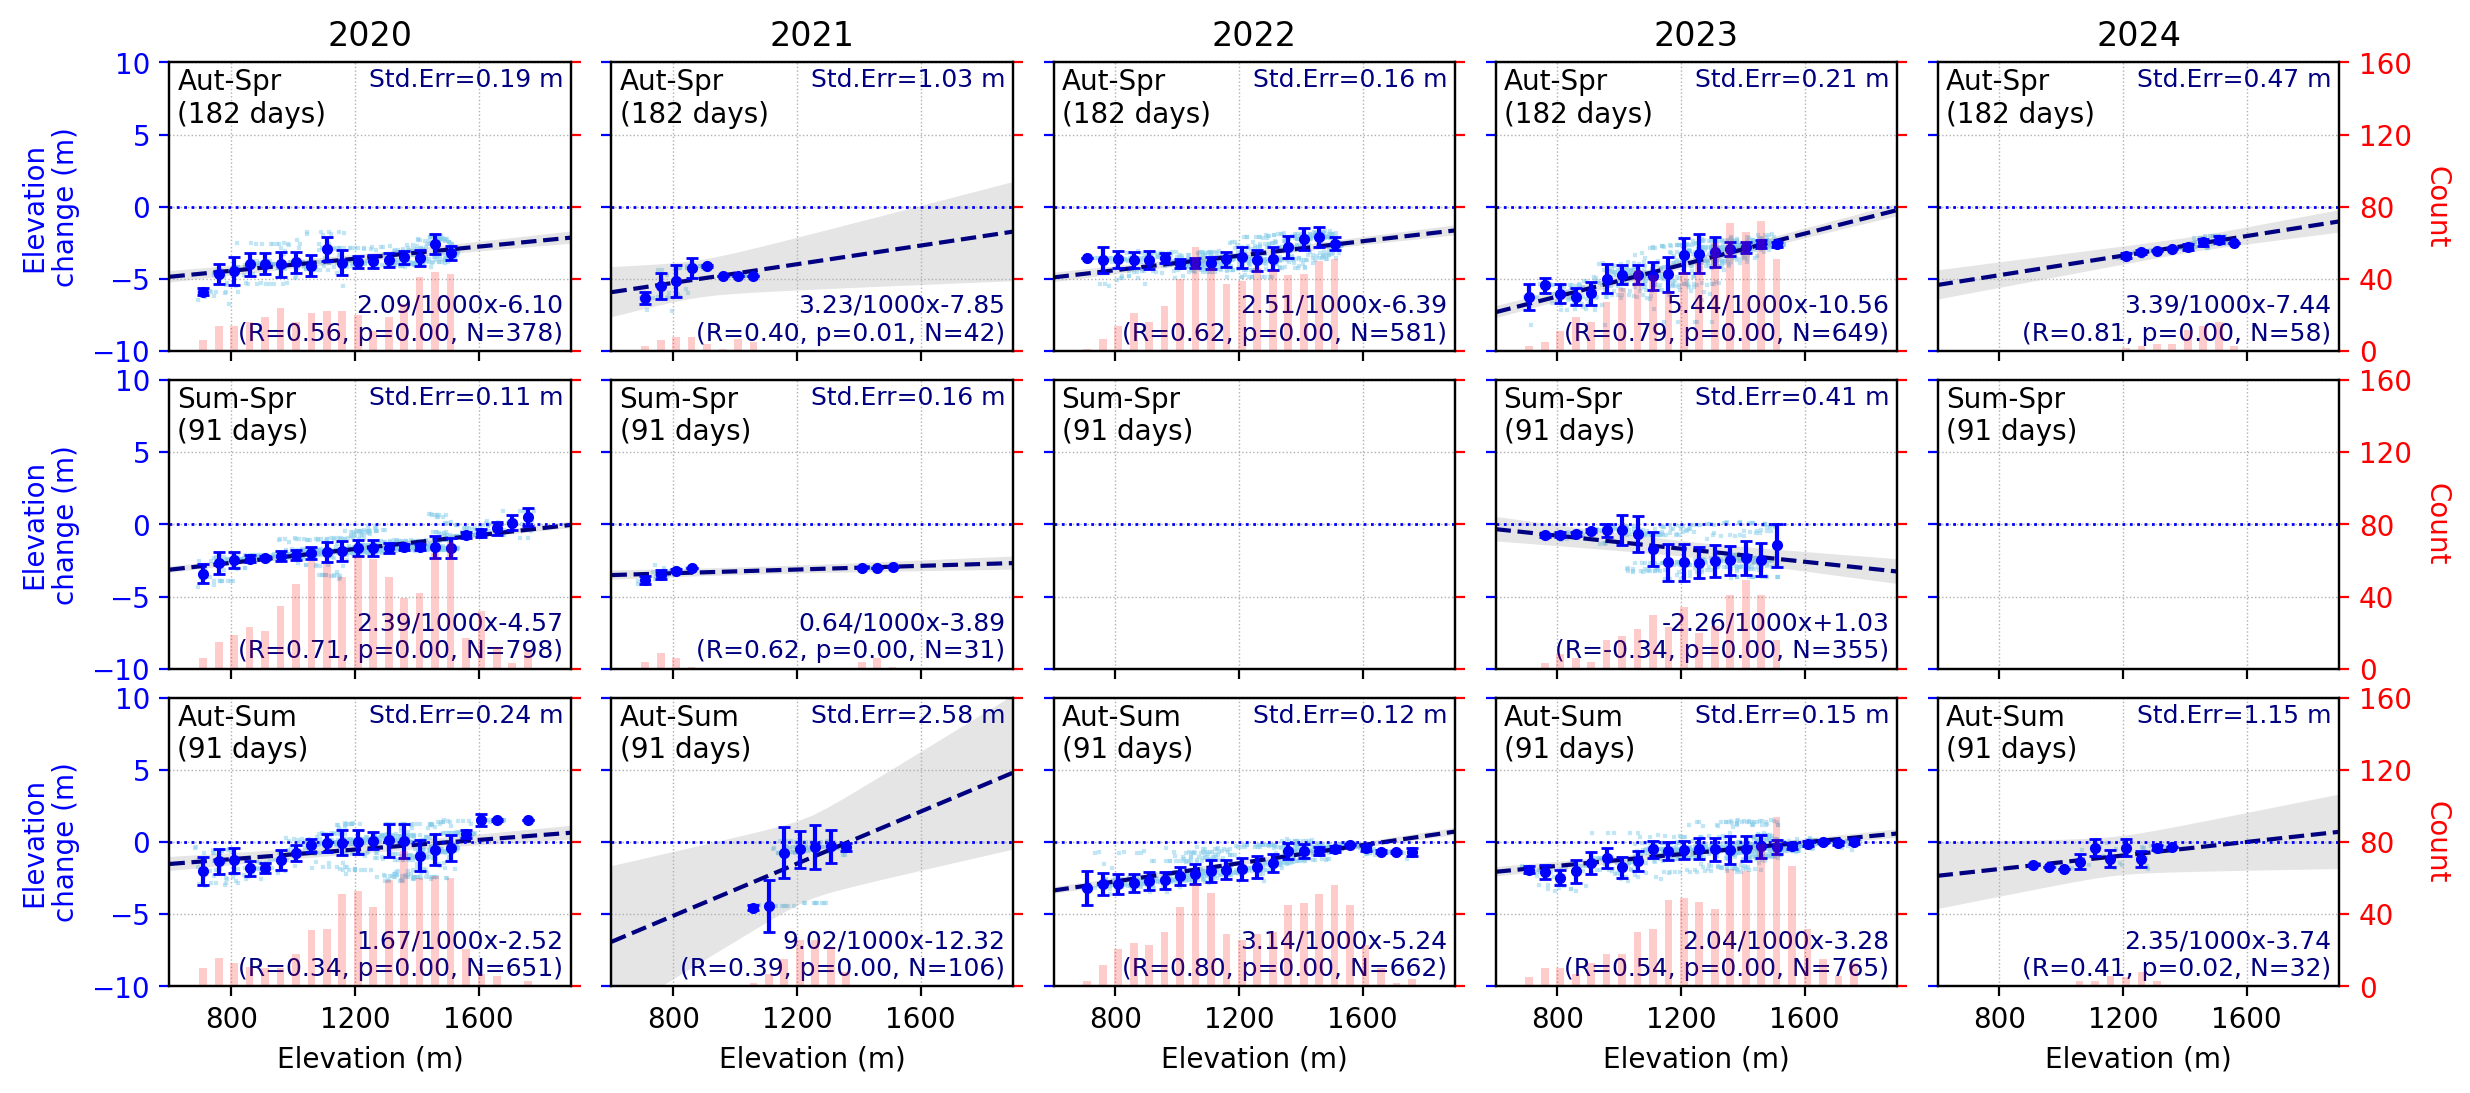

In [680]:
th_cats = [0, 1, 2]
th_season = ["Aut-Spr\n(182 days)", "Sum-Spr\n(91 days)", "Aut-Sum\n(91 days)", ""]

fig, ax = plt.subplots(len(th_cats), 5, figsize=(14, len(th_cats)*2), dpi = 200, sharex = True, sharey = True)
fig.subplots_adjust(wspace = 0.1, hspace = 0.1)

spacing = res
print(res)

for j, th_cat in enumerate(th_cats):

    for k in range(1, len(dh_sum)):
        if th_cat == 3:
            cat1 = cat_sum[k]
            target = cat1 * np.nan
            target = np.where(cat1 == 1, dh_sum[k][0], target)
            target = np.where(cat1 == 2, dh_sum[k][1], target)
            target = np.where(cat1 == 3, dh_sum[k][2], target)
        elif th_cat == 0:
            target = dh_sum[k][th_cat] #np.nansum(dh_sum[k][0:2]*cnt_sum[k][0:2], axis = 0) / np.nansum(cnt_sum[k][0:2], axis = 0) #dh_sum[k][th_cat]
        else:
            target = dh_sum[k][th_cat] * 0.5
        # target[cnt_sum[k] >= th_cat] = np.nan
        dh_dem = xdem.DEM.from_array(target, (spacing, 0.0, xp[0, 0], 0.0, spacing, yp[0, 0]), 3057)
        dh_dem = xdem.dDEM(raster = dh_dem, start_time=datetime(years[k], 4, 1), end_time=datetime(years[k], 10, 1))
        mask = glaciers.create_mask(dh_dem)
    
        ddem_bins = xdem.volume.hypsometric_binning(dh_dem[mask], ref_dem[mask])
        values = ddem_bins["value"].values
        
        x = ref_dem[mask].data.flatten()
        y = dh_dem[mask].data.flatten()
        idx = (abs(x) > 0) & (abs(y) > 0)
        x = x[idx]
        y = y[idx]

        ax2 = ax[j, k-1].twinx()
        
        if len(x) * len(y) > 0:
            reg = stats.linregress(x, y)
            
            a = reg.slope
            b = reg.intercept
            stderr = reg.intercept_stderr

            # regts = TheilSenRegressor(random_state=0).fit(x.reshape(-1, 1), y.reshape(-1, 1))
            # a = regts.coef_[0]
            # b = regts.intercept_
            
            x0 = np.arange(600, 2000, 50)
            y_fit = a*x+b
            conf = get_confidence_interval(x, y, y_fit, x0)
            rmse = np.nanmean((y - (y_fit))**2) ** 0.5
            
            ax[j, k-1].scatter(x, y, color = "skyblue", s = 3, marker = "+", alpha = 0.5, ec = "None")
            y0 = a*x0+b
            ax[j, k-1].plot(x0, y0, color = "navy", ls = "--")
            ax[j, k-1].fill_between(x0, y0-conf-stderr, y0+conf+stderr, color = "gray", alpha = 0.2, ec = "None")
            if b >= 0:
                ax[j, k-1].annotate(f"{1000*a:.2f}/1000x+{b:.2f}\n(R={reg.rvalue:.2f}, p={reg.pvalue:.2f}, N={len(x)})", xy=(0.98,0.02), xycoords='axes fraction',
                            color = "navy", fontsize=9, ha='right', va='bottom')
            else:
                ax[j, k-1].annotate(f"{1000*a:.2f}/1000x{b:.2f}\n(R={reg.rvalue:.2f}, p={reg.pvalue:.2f}, N={len(x)})", xy=(0.98,0.02), xycoords='axes fraction',
                            color = "navy", fontsize=9, ha='right', va='bottom')
            ax[j, k-1].annotate(f"Std.Err={stderr:.2f} m", xy=(0.98,0.98), xycoords='axes fraction', color = "navy", fontsize = 9, ha = "right", va = "top")
            
            df = xdem.volume.hypsometric_binning(dh_dem[mask], ref_dem[mask], aggregation_function=np.std)
            stds = df.value.values
            count = df['count'].values
            
            ax[j, k-1].errorbar(ddem_bins.index.mid, values, yerr = stds, marker='o', markersize=3, ls='none',  color = "b", capsize = 2)
            
            w = (ddem_bins.index.mid[1] - ddem_bins.index.mid[0])*0.5
            
            ax2.bar(ddem_bins.index.mid, count, width = w, color = "r", alpha = 0.2, zorder = 0)
        
        ax2.tick_params(axis='y', colors='r')
        ymin, ymax = ax2.set_ylim(0, 800/(res/100))
        if k != 5:
            ax2.set_yticks(np.linspace(ymin, ymax, 5), ["", "", "", "", ""])
        else:
            ax2.set_yticks(np.linspace(ymin, ymax, 5))

        ax[j, k-1].tick_params(axis='y', colors='b')
        ax[j, k-1].set_ylim(-10, 10)
        ax[j, k-1].grid(ls = ":", lw = 0.5)
        ax[j, k-1].axhline(0, color = "b", lw = 1, ls = ":")
        ax[j, k-1].set_xticks(np.arange(800, 2000, 400))
        ax[j, k-1].set_xlim(600, 1900)        
        ax[j, k-1].annotate(th_season[th_cat], xy=(0.02,0.98), xycoords='axes fraction', fontsize=10, ha='left', va='top')
        
        if th_cat == th_cats[-1]:
            ax[j, k-1].set_xlabel("Elevation (m)")
        elif th_cat == 0:
            ax[j, k-1].set_title(years[k])
        if k == 1:
            ax[j, k-1].set_ylabel("Elevation\nchange (m)", color = "b")
        if k == 5:
            ax2.set_ylabel("Count", rotation = 270, va = "bottom", color = "r")

            # ax.annotate(title, xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top')

# if figname:
#     plt.savefig(figname, bbox_inches="tight")   

500


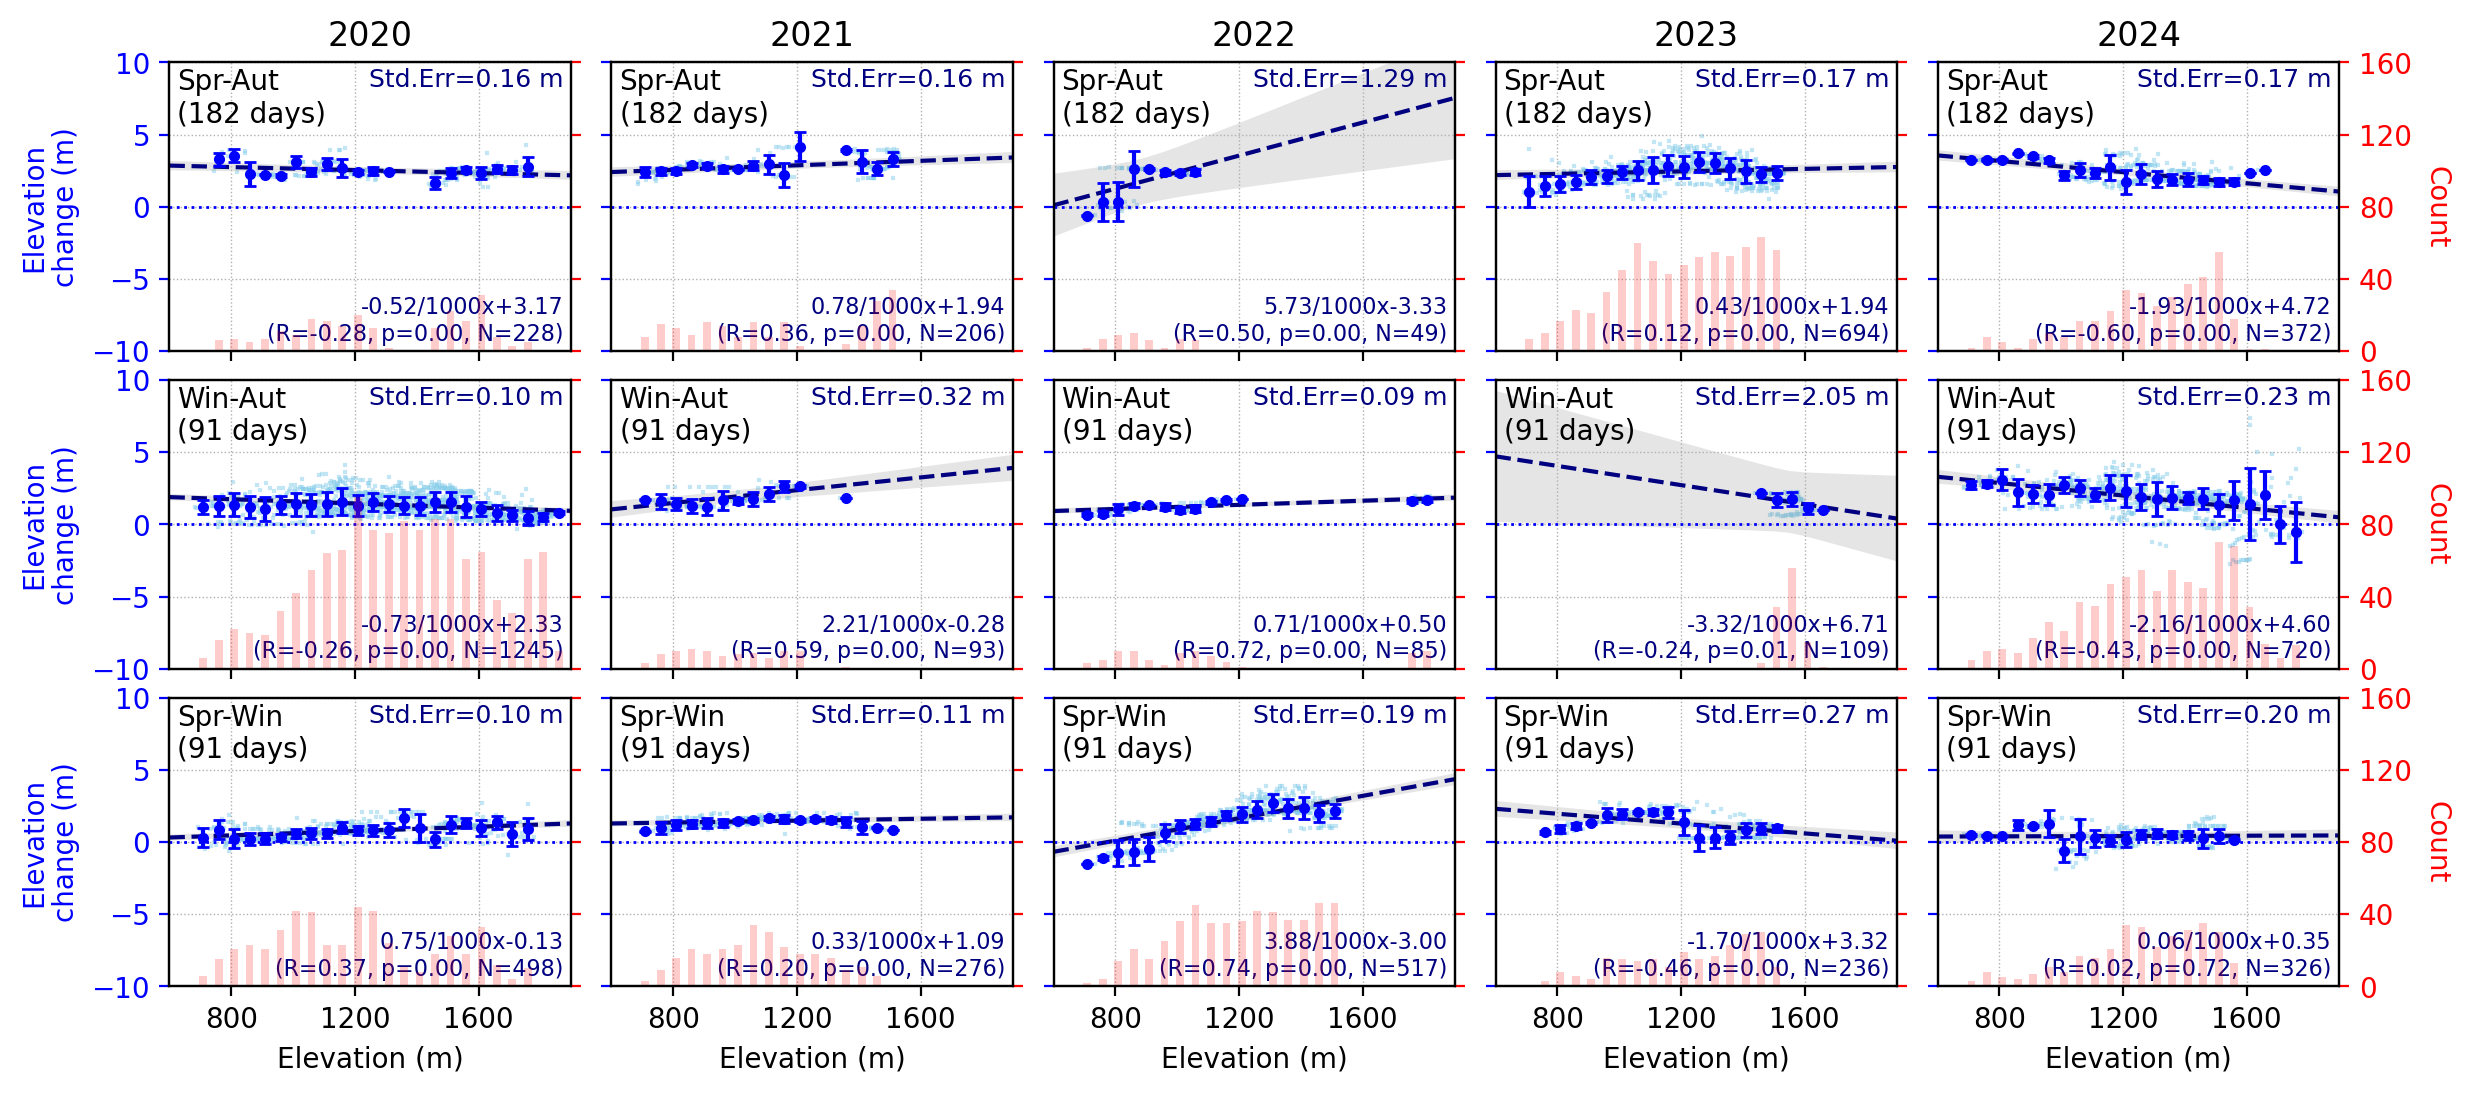

In [681]:
th_cats = [0, 1, 2]
th_season = ["Spr-Aut\n(182 days)", "Win-Aut\n(91 days)", "Spr-Win\n(91 days)", ""]

fig, ax = plt.subplots(len(th_cats), 5, figsize=(14, len(th_cats)*2), dpi = 200, sharex = True, sharey = True)
fig.subplots_adjust(wspace = 0.1, hspace = 0.1)

spacing = res
print(res)

for j, th_cat in enumerate(th_cats):

    for k in range(1, len(dh_win)):
        if th_cat == 3:
            cat1 = cat_win[k]
            target = cat1 * np.nan
            target = np.where(cat1 == 1, dh_win[k][0], target)
            target = np.where(cat1 == 2, dh_win[k][1], target)
            # target = np.where(cat1 == 3, dh_win[k][2], target)
        elif th_cat == 0:
            target = dh_win[k][th_cat] #np.nansum(dh_sum[k][0:2]*cnt_sum[k][0:2], axis = 0) / np.nansum(cnt_sum[k][0:2], axis = 0) #dh_sum[k][th_cat]
        else:
            target = dh_win[k][th_cat] * 0.5
        # target[cnt_sum[k] >= th_cat] = np.nan
        dh_dem = xdem.DEM.from_array(target, (spacing, 0.0, xp[0, 0], 0.0, spacing, yp[0, 0]), 3057)
        dh_dem = xdem.dDEM(raster = dh_dem, start_time=datetime(years[k], 4, 1), end_time=datetime(years[k], 10, 1))
        mask = glaciers.create_mask(dh_dem)
    
        ddem_bins = xdem.volume.hypsometric_binning(dh_dem[mask], ref_dem[mask])
        values = ddem_bins["value"].values
        
        x = ref_dem[mask].data.flatten()
        y = dh_dem[mask].data.flatten()
        idx = (abs(x) > 0) & (abs(y) > 0)
        x = x[idx]
        y = y[idx]

        ax2 = ax[j, k-1].twinx()
        
        if len(x) * len(y) > 0:
            reg = stats.linregress(x, y)
            reg2 = np.poly1d(np.polyfit(x, y, 3))
            
            a = reg.slope
            b = reg.intercept
            stderr= reg.intercept_stderr

            # regts = TheilSenRegressor(random_state=42).fit(x.reshape(-1, 1), y.reshape(-1, 1))
            # a = regts.coef_[0]
            # b = regts.intercept_
            
            x0 = np.arange(600, 2000, 50)
            y_fit = a*x+b
            conf = get_confidence_interval(x, y, y_fit, x0)
            rmse = np.nanmean((y - (y_fit))**2) ** 0.5
            
            ax[j, k-1].scatter(x, y, color = "skyblue", s = 3, marker = "+", alpha = 0.5, ec = "None")
            y0 = a*x0+b
            ax[j, k-1].plot(x0, y0, color = "navy", ls = "--")
            ax[j, k-1].fill_between(x0, y0-conf-stderr, y0+conf+stderr, color = "gray", alpha = 0.2, ec = "None")
            if b >= 0:
                ax[j, k-1].annotate(f"{1000*a:.2f}/1000x+{b:.2f}\n(R={reg.rvalue:.2f}, p={reg.pvalue:.2f}, N={len(x)})", xy=(0.98,0.02), xycoords='axes fraction',
                            color = "navy", fontsize=8, ha='right', va='bottom')
            else:
                ax[j, k-1].annotate(f"{1000*a:.2f}/1000x{b:.2f}\n(R={reg.rvalue:.2f}, p={reg.pvalue:.2f}, N={len(x)})", xy=(0.98,0.02), xycoords='axes fraction',
                            color = "navy", fontsize=8, ha='right', va='bottom')
            ax[j, k-1].annotate(f"Std.Err={stderr:.2f} m", xy=(0.98,0.98), xycoords='axes fraction', color = "navy", fontsize = 9, ha = "right", va = "top")
        
            df = xdem.volume.hypsometric_binning(dh_dem[mask], ref_dem[mask], aggregation_function=np.std)
            stds = df.value.values
            count = df['count'].values
            
            ax[j, k-1].errorbar(ddem_bins.index.mid, values, yerr = stds, marker='o', markersize=3, ls='none',  color = "b", capsize = 2)
            
            w = (ddem_bins.index.mid[1] - ddem_bins.index.mid[0])*0.5
            
            ax2.bar(ddem_bins.index.mid, count, width = w, color = "r", alpha = 0.2, zorder = 0)
        
        ax2.tick_params(axis='y', colors='r')
        ymin, ymax = ax2.set_ylim(0, 800/(res/100))
        if k != 5:
            ax2.set_yticks(np.linspace(ymin, ymax, 5), ["", "", "", "", ""])
        else:
            ax2.set_yticks(np.linspace(ymin, ymax, 5))

        ax[j, k-1].tick_params(axis='y', colors='b')
        ax[j, k-1].set_ylim(-10, 10)
        ax[j, k-1].grid(ls = ":", lw = 0.5)
        ax[j, k-1].axhline(0, color = "b", lw = 1, ls = ":")
        ax[j, k-1].set_xticks(np.arange(800, 2000, 400))
        ax[j, k-1].set_xlim(600, 1900)
        ax[j, k-1].annotate(th_season[th_cat], xy=(0.02,0.98), xycoords='axes fraction', fontsize=10, ha='left', va='top')

        if th_cat == th_cats[-1]:
            ax[j, k-1].set_xlabel("Elevation (m)")
        elif th_cat == 0:
            ax[j, k-1].set_title(years[k])
        if k == 1:
            ax[j, k-1].set_ylabel("Elevation\nchange (m)", color = "b")
        if k == 5:
            ax2.set_ylabel("Count", rotation = 270, va = "bottom", color = "r")

            # ax.annotate(title, xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top')

# if figname:
#     plt.savefig(figname, bbox_inches="tight")   

### Draw maps

200
Done!


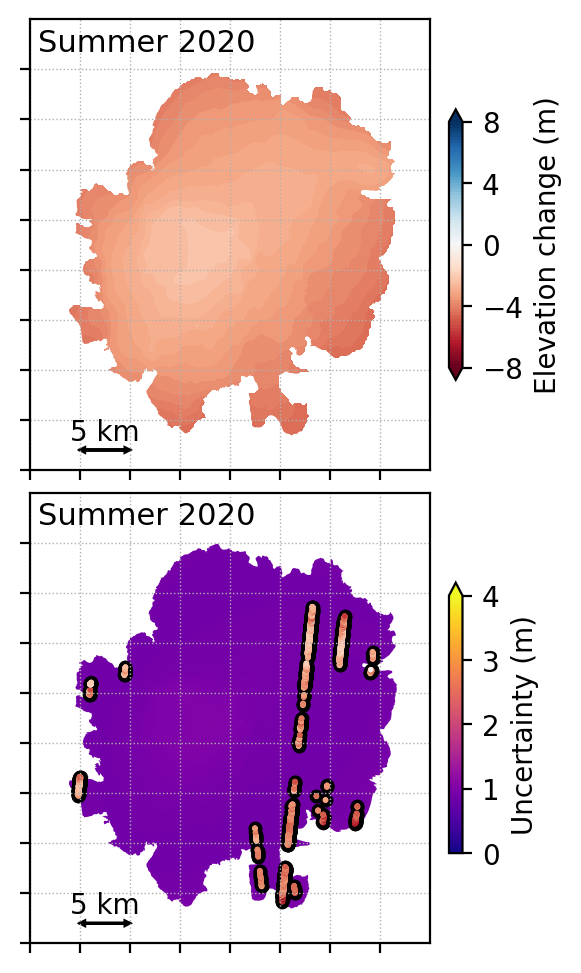

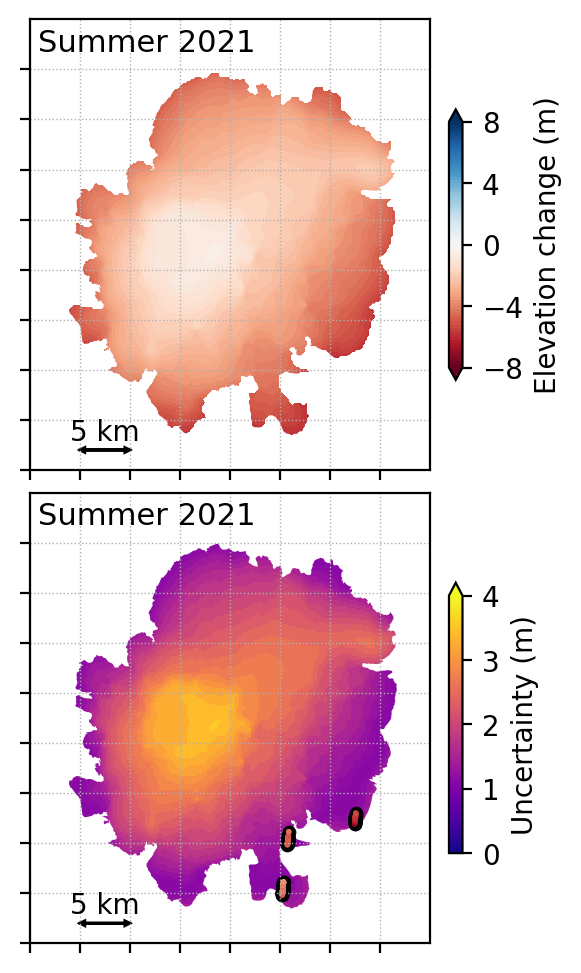

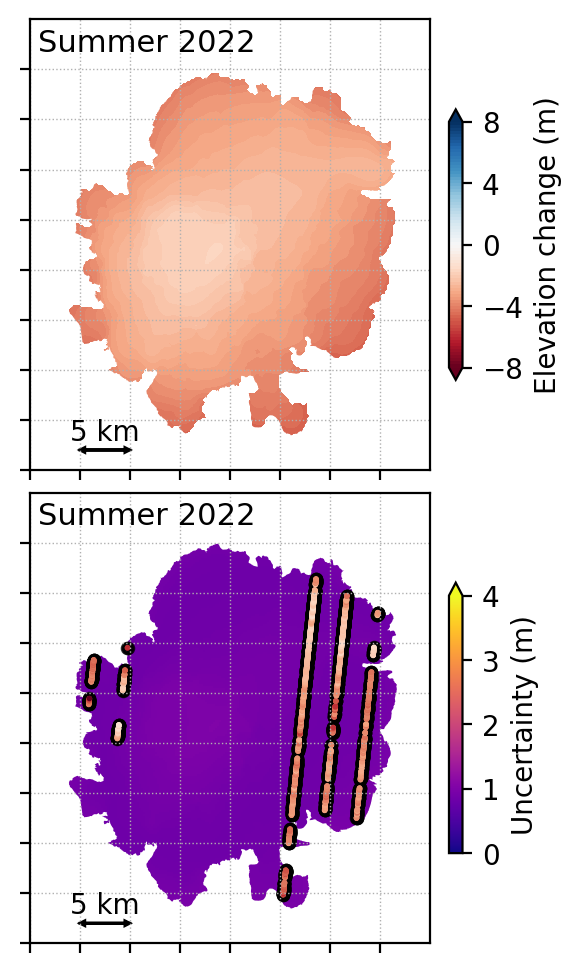

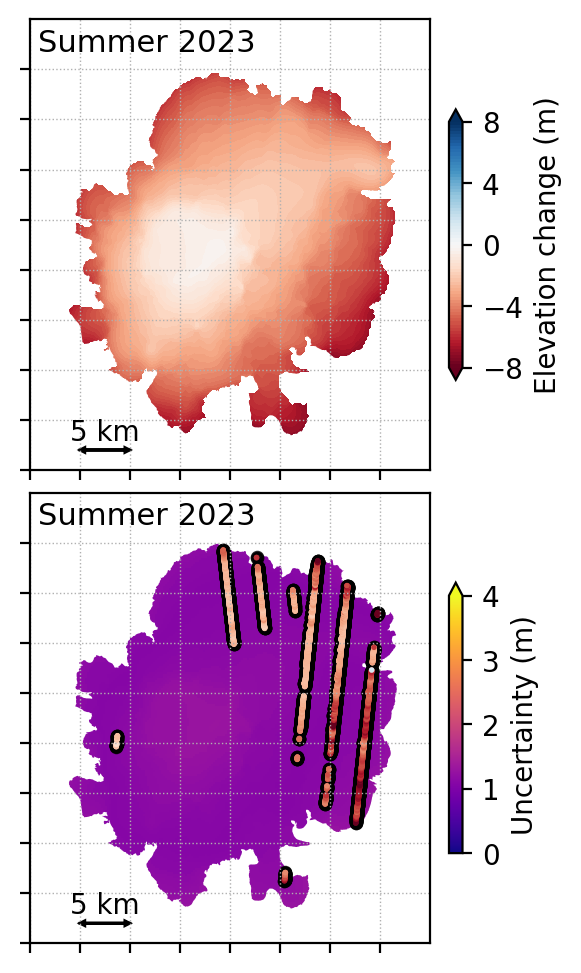

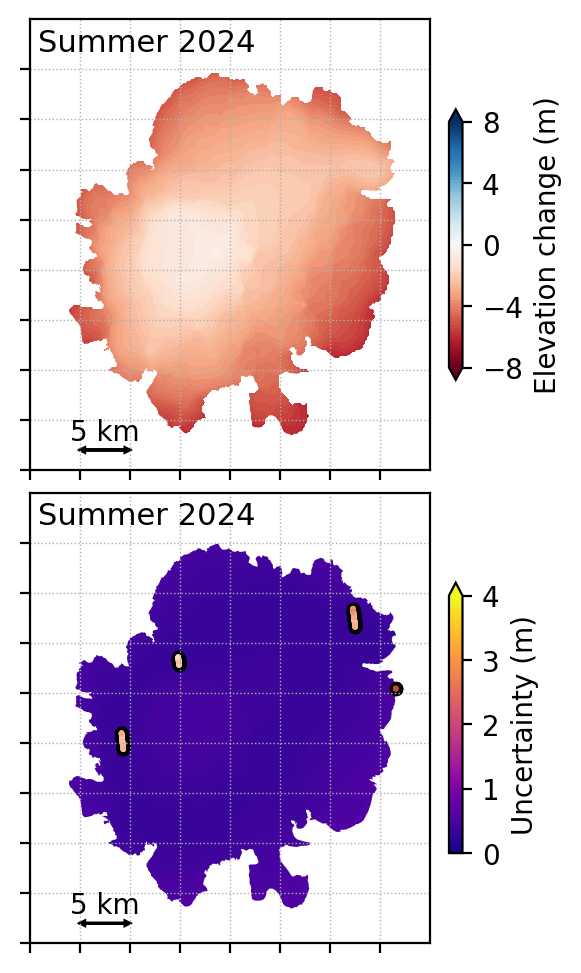

In [495]:
# Summer
spacing = res
xx, yy = xp, yp;
krg_sum = np.zeros([len(dh_sum), xx.shape[0], xx.shape[1]])
krg_sum_s2 = np.zeros([len(dh_sum), xx.shape[0], xx.shape[1]])

th_cat = 0
print(res)

for k in range(1, len(dh_sum)):
  target = dh_sum[k][th_cat] #np.nansum(dh_sum[k][0:2]*cnt_sum[k][0:2], axis = 0) / np.nansum(cnt_sum[k][0:2], axis = 0) #dh_sum[k][th_cat]
  # target[cnt_sum[k] >= th_cat] = np.nan
  dh_dem = xdem.DEM.from_array(target, (spacing, 0.0, xp[0, 0], 0.0, spacing, yp[0, 0]), 3057)
  dh_dem = xdem.dDEM(raster = dh_dem, start_time=datetime(years[k], 4, 1), end_time=datetime(years[k], 10, 1))
  mask = glaciers.create_mask(ref_dem)

  ### Linear hypsometric interpolation 
  target_gdf = gdf_sum[k][gdf_sum[k]['category'] == th_cat+1] #gdf_sum[k]
  # field, s2 = hypsometric_raw(ref_dem, mask, gdf = target_gdf) 
  field, s2 = hypsometric(dh_dem, ref_dem, mask) 

  krg_sum[k] = field
  krg_sum_s2[k] = s2
  
  map_name = f"D:\\Iceland\\Figure\\Map_{years[k]}_sum_{th_cat}"
  draw_plot(xp, yp, field, s2, outside, target_gdf, "Summer "+ str(years[k]), map_name)
  hyp_name = f"D:\\Iceland\\Figure\\Hypsometry_{years[k]}_sum_{th_cat}"
  # draw_hypsometry(dh_dem[mask], ref_dem[mask], "Summer "+ str(years[k]), hyp_name)

print("Done!")

Done!


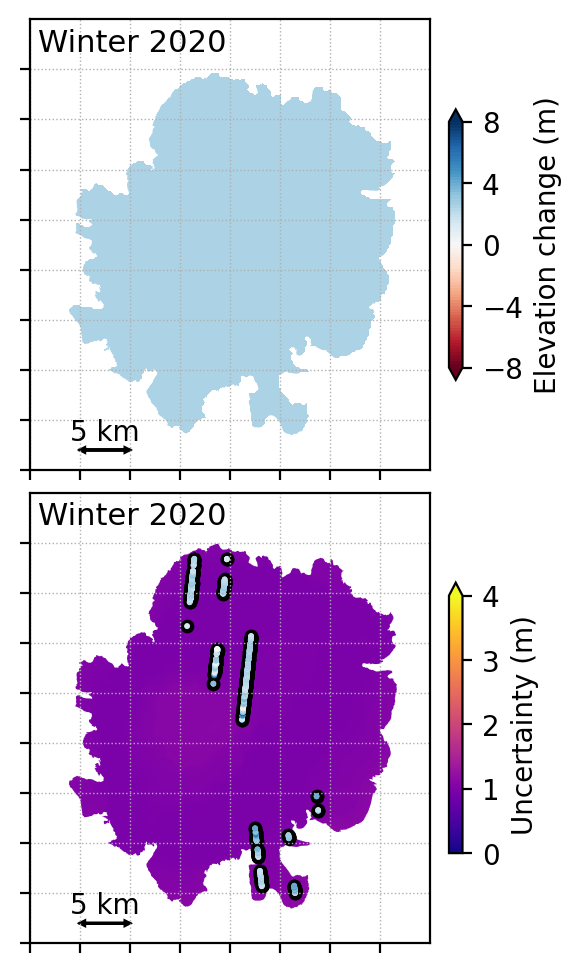

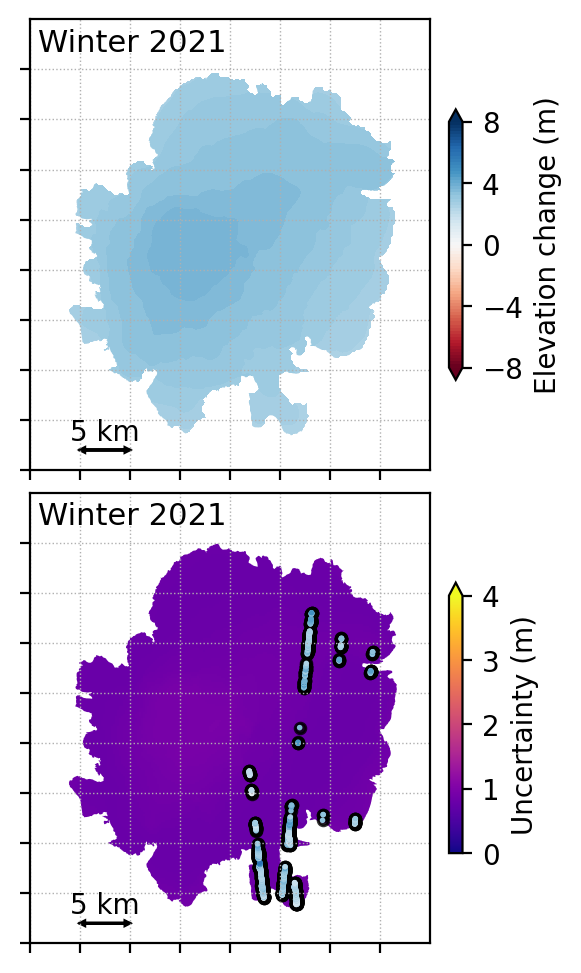

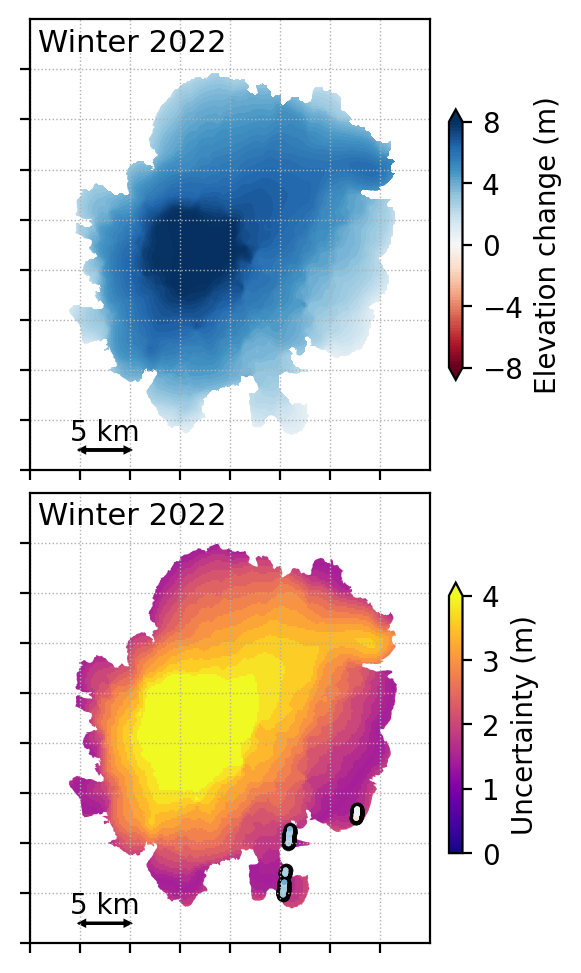

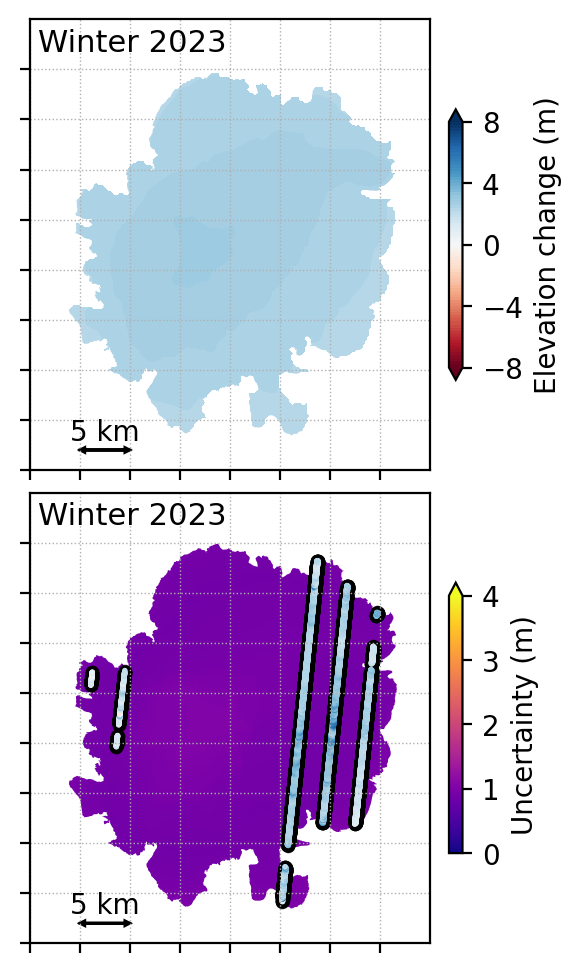

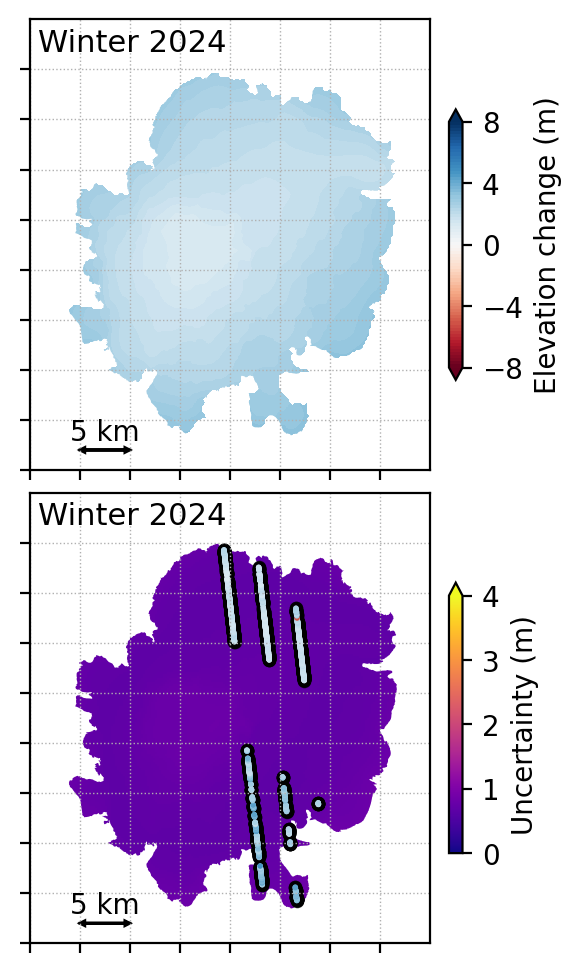

In [496]:
# Winter
xx, yy = xp, yp;
krg_win = np.zeros([len(dh_win), xx.shape[0], xx.shape[1]])
krg_win_s2 = np.zeros([len(dh_win), xx.shape[0], xx.shape[1]])

for k in range(1, len(dh_win)):
  target = dh_win[k][th_cat] #np.nansum(dh_win[k]*cnt_win[k], axis = 0) / np.nansum(cnt_win[k], axis = 0) #dh_win[k][th_cat]
  # target[cnt_win[k] >= th_cat] = np.nan
  dh_dem = xdem.DEM.from_array(target, (spacing, 0.0, xp[0, 0], 0.0, spacing, yp[0, 0]), 3057)
  dh_dem = xdem.dDEM(raster = dh_dem, start_time=datetime(years[k]-1, 10, 1), end_time=datetime(years[k], 4, 1))
  mask = glaciers.create_mask(ref_dem)  

  ### Linear hypsometric interpolation
  target_gdf = gdf_win[k][gdf_win[k]['category'] == th_cat + 1]
  # field, s2 = hypsometric_raw(ref_dem, mask, gdf = target_gdf) 
  field, s2 = hypsometric(dh_dem, ref_dem, mask)
    
  krg_win[k] = field
  krg_win_s2[k] = s2
    
  map_name = f"D:\\Iceland\\Figure\\Map_win_{years[k]}_{th_cat}"
  draw_plot(xp, yp, field, s2, outside, target_gdf, "Winter "+ str(years[k]), map_name)
  hyp_name = f"D:\\Iceland\\Figure\\Hypsometry_win_{years[k]}_{th_cat}"
  # draw_hypsometry(dh_dem[mask], ref_dem[mask], "Winter "+ str(years[k]), hyp_name, gdf = target_gdf)

print("Done!")

### Average time series

In [38]:
# Summer
spacing = res
xx, yy = xp, yp;

krg_sum = np.zeros([len(dh_sum), xx.shape[0], xx.shape[1]])
krg_sum_s = np.zeros([len(dh_sum), xx.shape[0], xx.shape[1]])

th_cat = "averaged"
print(res)

gdf_sum_final = []

for k in tqdm(range(1, len(dh_sum))):
    gdf_filter = gdf_filtering(gdf_sum[k], "sum")
    gdf_sum_final.append(gdf_filter)
    idh, s2 = hypsometric_raw_average(ref_dem.data.data, mask.data.data, gdf_filter)
    # w = (1/s2) / np.nansum(1/s2, axis = 0)
    # dh_map0 = np.nanmedian(idh, axis = (0, 1))
    # dh_map = np.nansum(idh, axis = (0, 1)) * np.nan
    row, col = idh.shape[-2], idh.shape[-1]

    # idh0 = np.zeros([36, 12, row, col]) * np.nan
    # s0 = np.zeros([36, 12, row, col]) * np.nan
    # for c in [0, 1, 2]:
    #     for m in range(1, 13):
    #         idh0[c*12 + m-1] = idh[c, m-1]
    #         s0[c*12 + m-1] = s2[c, m-1]
    
    w = (1/s2) / np.nansum(1/s2, axis = (0, 1))
    dh_map = np.nansum(idh * w, axis = (0, 1))
    dh_map[dh_map == 0] = np.nan
    
    # dh_map = np.nanmedian(idh, axis = (0, 1))
    s_map = np.nanmedian(s2, axis = (0, 1))
    
    krg_sum[k] = np.nanmean(dh_map[3:9], axis = 0) * np.sum(np.count_nonzero(~np.isnan(dh_map[3:9]), axis = (1,2))/len(ref_dem[mask]))
    krg_sum_s[k] = np.nansum(s_map[3:9], axis = 0)

    map_name = f"C:\\Users\\yoko2261\\OneDrive - UCB-O365\\Documents\\paper_submission\\Iceland_glacier\\Map_spline_sum_{res}_{years[k]}_{th_cat}"
    draw_plot(xp, yp, krg_sum[k], krg_sum_s[k], outside, gdf_filter, "Summer "+ str(years[k]), map_name)
    
hyp_name = f"C:\\Users\\yoko2261\\OneDrive - UCB-O365\\Documents\\paper_submission\\Iceland_glacier\\Hypsometry_spline_sum_all"
draw_hypsometry_raw(gdf_sum_final, res, "sum", hyp_name)

print("Summer Done!")

100


100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.99s/it]


Summer Done!


In [40]:
# Winter
spacing = res
xx, yy = xp, yp;

krg_win = np.zeros([len(dh_win), xx.shape[0], xx.shape[1]])
krg_win_s = np.zeros([len(dh_win), xx.shape[0], xx.shape[1]])

th_cat = "averaged"
print(res)

gdf_win_final = []

for k in tqdm(range(1, len(dh_sum))):
    gdf_filter = gdf_filtering(gdf_win[k], "win")
    gdf_win_final.append(gdf_filter)
    idh, s2 = hypsometric_raw_average(ref_dem.data.data, mask.data.data, gdf_filter)    

    w = (1/s2) / np.nansum(1/s2, axis = (0, 1))
    dh_map0 = np.nansum(idh * w, axis = (0, 1))
    
    # dh_map = np.nanmedian(idh, axis = (0, 1))
    s_map0 = np.nanmedian(s2, axis = (0, 1))
    
    # dh_map0 = np.nanmedian(idh, axis = (0, 1))
    dh_map = dh_map0 * np.nan
    # s_map0 = np.nanmean(s2, axis = (0, 1))
    s_map = s_map0 * np.nan
    
    for m in range(1, 13):
        dh_map[convert_month(m, 6)-1] = dh_map0[m-1]
        s_map[convert_month(m, 6)-1] = s_map0[m-1]

    dh_map[dh_map == 0] = np.nan

    krg_win[k] = np.nanmean(dh_map[3:9], axis = 0) * np.sum(np.count_nonzero(~np.isnan(dh_map[3:9]), axis = (1,2))/len(ref_dem[mask]))
    krg_win_s[k] = np.nansum(s_map[3:9], axis = 0)

    map_name = f"C:\\Users\\yoko2261\\OneDrive - UCB-O365\\Documents\\paper_submission\\Iceland_glacier\\Map_spline_win_{res}_{years[k]}_{th_cat}"
    draw_plot(xp, yp, krg_win[k], krg_win_s[k], outside, gdf_filter, "Winter "+ str(years[k]), map_name)

hyp_name = f"C:\\Users\\yoko2261\\OneDrive - UCB-O365\\Documents\\paper_submission\\Iceland_glacier\\Hypsometry_spline_win_all"
draw_hypsometry_raw(gdf_win_final, res, "win", hyp_name)

print("Winter Done!")

100


100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.14s/it]


Winter Done!


In [23]:
fig_name = f"C:\\Users\\yoko2261\\OneDrive - UCB-O365\\Documents\\paper_submission\\Iceland_glacier\\Map_win_IS2_track"
draw_maps(gdf_win_final, ref_dem.data.data, xp, yp, season = "win", figname = fig_name)

fig_name = f"C:\\Users\\yoko2261\\OneDrive - UCB-O365\\Documents\\paper_submission\\Iceland_glacier\\Map_sum_IS2_track"
draw_maps(gdf_sum_final, ref_dem.data.data, xp, yp, season = "sum", figname = fig_name)

### Combine multiple time-series data

In [266]:
# Summer
spacing = res
xx, yy = xp, yp;
krg_sum1 = np.zeros([len(dh_sum), xx.shape[0], xx.shape[1]])
krg_sum_s1 = np.zeros([len(dh_sum), xx.shape[0], xx.shape[1]])
krg_sum2 = np.zeros([len(dh_sum), xx.shape[0], xx.shape[1]])
krg_sum_s2 = np.zeros([len(dh_sum), xx.shape[0], xx.shape[1]])
krg_sum = np.zeros([len(dh_sum), xx.shape[0], xx.shape[1]])
krg_sum_s = np.zeros([len(dh_sum), xx.shape[0], xx.shape[1]])

th_cat = "averaged"
print(res)

for k in range(1, len(dh_sum)):
    cat1 = cat_sum[k]    

    target1 = dh_sum[k][0]
    target2 = dh_sum[k][1]*0.5
    target3 = dh_sum[k][2]*0.5
    dh1 = xdem.DEM.from_array(target1, (spacing, 0.0, xp[0, 0], 0.0, spacing, yp[0, 0]), 3057)
    dh1 = xdem.dDEM(raster = dh1, start_time=datetime(years[k], 4, 1), end_time=datetime(years[k], 10, 1))
    dh2 = xdem.DEM.from_array(target2, (spacing, 0.0, xp[0, 0], 0.0, spacing, yp[0, 0]), 3057)
    dh2 = xdem.dDEM(raster = dh2, start_time=datetime(years[k], 4, 1), end_time=datetime(years[k], 7, 1))
    dh3 = xdem.DEM.from_array(target3, (spacing, 0.0, xp[0, 0], 0.0, spacing, yp[0, 0]), 3057)
    dh3 = xdem.dDEM(raster = dh3, start_time=datetime(years[k], 7, 1), end_time=datetime(years[k], 10, 1))
    mask = glaciers.create_mask(dh1)
    
    ### Linear hypsometric interpolation 
    field1, s1 = hypsometric(dh1, ref_dem, mask)
    field2, s2 = hypsometric(dh2, ref_dem, mask) 
    field3, s3 = hypsometric(dh3, ref_dem, mask)
    field2 = np.where(np.isnan(field2), field1/2, field2)
    field3 = np.where(np.isnan(field3), field1/2, field3)
    s2 = np.where(np.isnan(s2), s1/2, s2)
    s3 = np.where(np.isnan(s3), s1/2, s3)

    krg_sum1[k] = field1
    krg_sum_s1[k] = s1

    krg_sum2[k] = field2 + field3
    krg_sum_s2[k] = s2 + s3

    w1 = 0.5 #(1/krg_sum_s1[k]**2) / (1/krg_sum_s1[k]**2 + 1/krg_sum_s2[k]**2)
    w2 = 0.5 #(1/krg_sum_s2[k]**2) / (1/krg_sum_s1[k]**2 + 1/krg_sum_s2[k]**2)
    
    krg_sum[k] = (krg_sum1[k]*w1 + krg_sum2[k]*w2)
    krg_sum_s[k] = (krg_sum_s1[k]*w1 + krg_sum_s2[k]*w2)
    
    target_gdf = gdf_sum[k] #[gdf_win[k]['category'] == 1]
    target_gdf1 = gdf_sum[k][gdf_sum[k]['category'] == 1]
    target_gdf2 = gdf_sum[k][gdf_sum[k]['category'] == 2]
    target_gdf3 = gdf_sum[k][gdf_sum[k]['category'] == 3]
    map_name = f"D:\\Iceland\\Figure\\R{res}\\Map_sum_{res}_{years[k]}_{th_cat}1"
    draw_plot(xp, yp, field1, s1, outside, target_gdf1, "Aut-Spr "+ str(years[k]), map_name)
    map_name = f"D:\\Iceland\\Figure\\R{res}\\Map_sum_{res}_{years[k]}_{th_cat}2"
    draw_plot(xp, yp, field2, s2, outside, target_gdf2, "Sum-Spr "+ str(years[k]), map_name)
    map_name = f"D:\\Iceland\\Figure\\R{res}\\Map_sum_{res}_{years[k]}_{th_cat}3"
    draw_plot(xp, yp, field3, s3, outside, target_gdf3, "Aut-Sum "+ str(years[k]), map_name)
    map_name = f"D:\\Iceland\\Figure\\R{res}\\Map_sum_{res}_{years[k]}_{th_cat}"
    draw_plot(xp, yp, krg_sum[k], krg_sum_s[k], outside, [], "Summer "+ str(years[k]), map_name)
    # hyp_name = f"D:\\Iceland\\Figure\\Hypsometry_{years[k]}_sum_{th_cat}"
    # draw_hypsometry(dh_dem[mask], ref_dem[mask], "Summer "+ str(years[k]), hyp_name)

print("Done!")

200
Done!


In [817]:
# Winter
xx, yy = xp, yp;
krg_win1 = np.zeros([len(dh_win), xx.shape[0], xx.shape[1]])
krg_win_s1 = np.zeros([len(dh_win), xx.shape[0], xx.shape[1]])
krg_win2 = np.zeros([len(dh_win), xx.shape[0], xx.shape[1]])
krg_win_s2 = np.zeros([len(dh_win), xx.shape[0], xx.shape[1]])
krg_win = np.zeros([len(dh_win), xx.shape[0], xx.shape[1]])
krg_win_s = np.zeros([len(dh_win), xx.shape[0], xx.shape[1]])

for k in range(1, len(dh_win)):
    cat1 = cat_win[k]

    target1 = dh_win[k][0]
    target2 = dh_win[k][1]*0.5
    target3 = dh_win[k][2]*0.5
    dh1 = xdem.DEM.from_array(target1, (spacing, 0.0, xp[0, 0], 0.0, spacing, yp[0, 0]), 3057)
    dh1 = xdem.dDEM(raster = dh1, start_time=datetime(years[k], 4, 1), end_time=datetime(years[k], 10, 1))
    dh2 = xdem.DEM.from_array(target2, (spacing, 0.0, xp[0, 0], 0.0, spacing, yp[0, 0]), 3057)
    dh2 = xdem.dDEM(raster = dh2, start_time=datetime(years[k], 4, 1), end_time=datetime(years[k], 7, 1))
    dh3 = xdem.DEM.from_array(target3, (spacing, 0.0, xp[0, 0], 0.0, spacing, yp[0, 0]), 3057)
    dh3 = xdem.dDEM(raster = dh3, start_time=datetime(years[k], 7, 1), end_time=datetime(years[k], 10, 1))
    mask = glaciers.create_mask(dh1)    
    
    ### Linear hypsometric interpolation 
    field1, s1 = hypsometric(dh1, ref_dem, mask)
    field2, s2 = hypsometric(dh2, ref_dem, mask) 
    field3, s3 = hypsometric(dh3, ref_dem, mask)
    field2 = np.where(np.isnan(field2), field1/2, field2)
    field3 = np.where(np.isnan(field3), field1/2, field3)
    s1 = np.where(np.isnan(s1), s1+0.01, s1+0.01)
    s2 = np.where(np.isnan(s2), s1/2, s2+0.01)
    s3 = np.where(np.isnan(s3), s1/2, s3+0.01)
    
    krg_win1[k] = field1
    krg_win_s1[k] = s1

    krg_win2[k] = field2 + field3
    krg_win_s2[k] = s2 + s3

    w1 = 0.5 # (1/krg_win_s1[k]**2) / (1/krg_win_s1[k]**2 + 1/krg_win_s2[k]**2)
    w2 = 0.5 # (1/krg_win_s2[k]**2) / (1/krg_win_s1[k]**2 + 1/krg_win_s2[k]**2)
    
    krg_win[k] = (krg_win1[k]*w1 + krg_win2[k]*w2)
    krg_win_s[k] = (krg_win_s1[k]*w1 + krg_win_s2[k]*w2)

    target_gdf = gdf_win[k] #[gdf_win[k]['category'] == 1]
    target_gdf1 = gdf_win[k][gdf_win[k]['category'] == 1]
    target_gdf2 = gdf_win[k][gdf_win[k]['category'] == 2]
    target_gdf3 = gdf_win[k][gdf_win[k]['category'] == 3]
    map_name = f"D:\\Iceland\\Figure\\R{res}\\Map_win_{res}_{years[k]}_{th_cat}1"
    draw_plot(xp, yp, field1, s1, outside, target_gdf1, "Spr-Aut "+ str(years[k]), map_name)
    map_name = f"D:\\Iceland\\Figure\\R{res}\\Map_win_{res}_{years[k]}_{th_cat}2"
    draw_plot(xp, yp, field2, s2, outside, target_gdf2, "Win-Aut "+ str(years[k]), map_name)
    map_name = f"D:\\Iceland\\Figure\\R{res}\\Map_win_{res}_{years[k]}_{th_cat}3"
    draw_plot(xp, yp, field3, s3, outside, target_gdf3, "Spr-Win "+ str(years[k]), map_name)
    map_name = f"D:\\Iceland\\Figure\\R{res}\\Map_win_{res}_{years[k]}_{th_cat}"
    draw_plot(xp, yp, krg_win[k], krg_win_s[k], outside, [], "Winter "+ str(years[k]), map_name)

    # hyp_name = f"D:\\Iceland\\Figure\\Hypsometry_win_{years[k]}_{th_cat}"
    # draw_hypsometry(dh_dem[mask], ref_dem[mask], "Winter "+ str(years[k]), hyp_name)

print("Done!")

Done!


# Convert elevation change to mass balance change

In [ ]:
%pip install rasterio

In [44]:
import rasterio

dh_dem = np.zeros(xx.shape)

# from matplotlib import pyplot
with rasterio.open(f"G:/My Drive/iceland_diff_20_jitcor.tif") as src:
  band_diff = src.read(1)
  # band1[band1 < 1100] = np.nan

  height = band_diff.shape[0]
  width = band_diff.shape[1]
  cols, rows = np.meshgrid(np.arange(width), np.arange(height))
  xxd, yyd = rasterio.transform.xy(src.transform, rows, cols)
  xxd = np.array(xxd).reshape(band_diff.shape)
  yyd = np.array(yyd).reshape(band_diff.shape)

  f = RegularGridInterpolator((yyd[:, 0], xxd[0]), band_diff, bounds_error=False, fill_value=None)
  dh_dem = f((yp, xp))

  # for i in tqdm(range(xx.shape[0])):
  #   for j in range(yy.shape[1]):
  #     dh_dem[i,j] = np.nanmean(band_diff[(abs(xxd - xx[i, j]) < spacing/2) & (abs(yyd - yy[i, j]) <  spacing/2)])

  print('Band_diff has shape', band_diff.shape)


# from matplotlib import pyplot
with rasterio.open(f"G:/My Drive/iceland_oct2020_20_jitcor.tif") as src:
  band1 = src.read(1)
  idx_nan = np.where(np.isnan(band1))
  for i in range(0, len(idx_nan[0])):
    band1[idx_nan[0][i], idx_nan[1][i]] = np.nanmean(band1[idx_nan[0][i]-1:idx_nan[0][i]+2,
                                                            idx_nan[1][i]-1:idx_nan[1][i]+2])
  # band1[band1 < 1100] = np.nan

  height = band1.shape[0]
  width = band1.shape[1]
  cols, rows = np.meshgrid(np.arange(width), np.arange(height))
  xxd, yyd = rasterio.transform.xy(src.transform, rows, cols)
  xxd = np.array(xxd).reshape(band1.shape)
  yyd = np.array(yyd).reshape(band1.shape)

  print('Band1 has shape', band1.shape)

Band_diff has shape (2180, 2059)
Band1 has shape (2180, 2059)


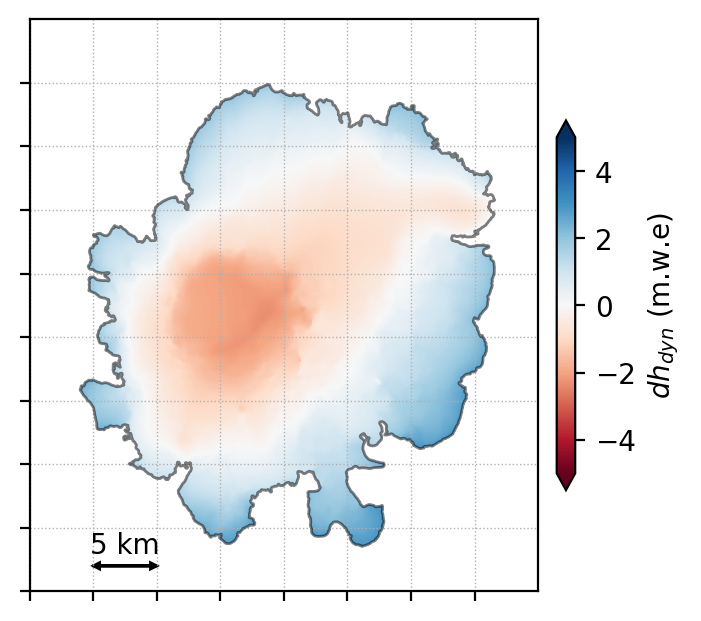

In [42]:
fig, ax = plt.subplots(1,1,figsize = (4,4), dpi = 200)

# ax.legend()
plt.axis('scaled')
# ax.title(f"{y} {season.upper()}")

shapefile.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.5)

a = 0.004584208473991501
b = -6.20352769584232

z = -(band1*a + b)
im = ax.pcolormesh(xxd, yyd, z, vmin = -5, vmax = 5, cmap = "RdBu")

x1, x2 = ax.set_xlim(488000, 528000)
y1, y2 = ax.set_ylim(457000, 502000)
ax.set_yticks(np.arange(y1, y2, 5000), [])
ax.set_xticks(np.arange(x1, x2, 5000), [])
ax.grid(ls = ":", lw = 0.5)

outside.plot(ax = ax, color = "w")

# im = cbar.get_images()[0]
fig.colorbar(im, shrink = 0.6, label = "$dh_{dyn}$ (m.w.e)", orientation = 'vertical', pad = 0.03, extend = "both")

# SCale bar
plt.annotate("5 km", xy=(488000 + 7500, 457000+3000), fontsize = 10, ha = "center")
ax.arrow(488000 + 5000, 457000+2000, 5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)
ax.arrow(488000 + 10000, 457000+2000, -5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)

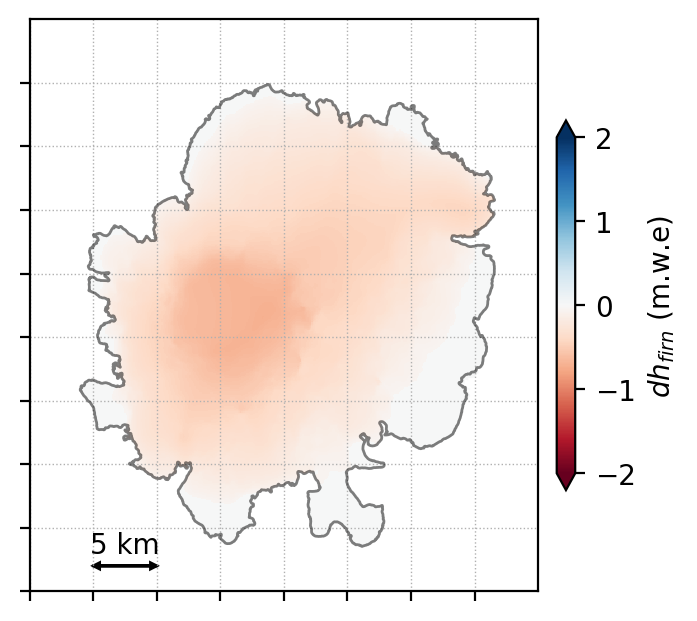

In [28]:
fig, ax = plt.subplots(1,1,figsize = (4,4), dpi = 200)

# ax.legend()
plt.axis('scaled')
# ax.title(f"{y} {season.upper()}")

shapefile.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.5)

z2 = get_firn(year, ref_dem.data.data)
im = ax.pcolormesh(xp, yp, z2, vmin = -2, vmax = 2, cmap = "RdBu")

x1, x2 = ax.set_xlim(488000, 528000)
y1, y2 = ax.set_ylim(457000, 502000)
ax.set_yticks(np.arange(y1, y2, 5000), [])
ax.set_xticks(np.arange(x1, x2, 5000), [])
ax.grid(ls = ":", lw = 0.5)

outside.plot(ax = ax, color = "w")

# im = cbar.get_images()[0]
fig.colorbar(im, shrink = 0.6, label = "$dh_{firn}$ (m.w.e)", orientation = 'vertical', pad = 0.03, extend = "both")

# SCale bar
plt.annotate("5 km", xy=(488000 + 7500, 457000+3000), fontsize = 10, ha = "center")
ax.arrow(488000 + 5000, 457000+2000, 5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)
ax.arrow(488000 + 10000, 457000+2000, -5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)

In [45]:
xx, yy = xp, yp; #np.meshgrid(np.arange(490000., 530000., 500), np.arange(460000., 500000., 500))

df_grid = pd.DataFrame({'x': xx.flatten(), 'y': yy.flatten(), 'flag': yy.flatten()*0})
gdf_grid = gpd.GeoDataFrame(df_grid, geometry=gpd.points_from_xy(df_grid.x, df_grid.y), crs="EPSG:3057")

dd = gpd.sjoin(left_df=gdf_grid, right_df=shapefile, how='inner')
df_grid.loc[dd.index, 'flag'] = 1
# Glacier flag
flag = df_grid['flag'].values.reshape(xx.shape[0], xx.shape[1])
flag = flag.astype(float)

dh_dyn = np.zeros(xx.shape)
dh_firn = np.zeros(xx.shape)

f_dyn = RegularGridInterpolator((yyd[:, 0], xxd[0]), z, bounds_error=False, fill_value=None)
dh_dyn = f_dyn((yp, xp))

# f_firn = RegularGridInterpolator((yyd[:, 0], xxd[0]), z2, bounds_error=False, fill_value=None)
# dh_firn = f_firn((yp, xp))

# for i in tqdm(range(xx.shape[0])):
#   for j in range(yy.shape[1]):
#     dh_dyn[i,j] = np.nanmean(z[(abs(xxd - xx[i, j]) < spacing/2) & (abs(yyd - yy[i, j]) <  spacing/2)])
#     dh_firn[i,j] = np.nanmean(z2[(abs(xxd - xx[i, j]) <  spacing/2) & (abs(yyd - yy[i, j]) < spacing/2)])

# dh_dyn = dh_dyn - np.nanmean(dh_dyn[flag == 1])

print("Done for ice dynamics and firn densification!")

Done for ice dynamics and firn densification!


2019 600.0 475.0
2020 600.0 475.0
2021 600.0 475.0
2022 600.0 475.0
2023 600.0 475.0
2024 600.0 475.0
Done!


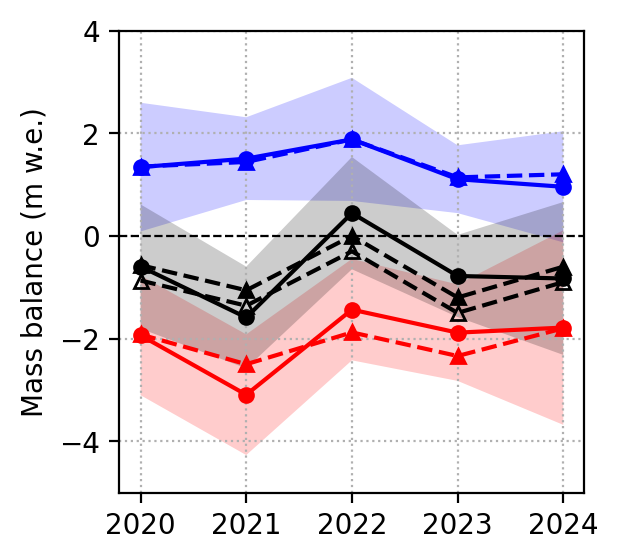

In [48]:
dh_sum_avg = np.nansum(krg_sum[1:5], axis = 0) #.shape
dh_win_avg = np.nansum(krg_win[1:5], axis = 0) #.shape
# dh_ann_avg = np.nanmean(krg_win[2:5] + krg_sum[2:5], axis = 0) #.shape
dh_ann_avg = dh_sum_avg + dh_win_avg
dh_ann_avg[flag == 0] = np.nan
# dh_dem[flag == 0] = np.nan

df_mb = pd.DataFrame()

mbs_grid = np.zeros(krg_sum.shape)
mbw_grid = np.zeros(krg_win.shape)
uncs_grid = np.zeros(krg_sum.shape)
uncw_grid = np.zeros(krg_win.shape)
mba_grid = np.zeros(krg_sum.shape)

dh_firn[np.isnan(dh_firn)] = 0
flag[flag == 0] = np.nan

cbsum = [np.nan, -1.92, -2.50, -1.88, -2.34, -1.80]
cbwin = [np.nan, 1.35, 1.44, 1.88, 1.14, 1.20]
rhos = np.zeros(np.array(years).shape)
rhow = np.zeros(np.array(years).shape)

krg_ann = krg_win + krg_sum

for i, year in enumerate(years[:]):
    insitu = pd.read_csv(f"G:/My Drive/Colab Notebooks/Iceland/Data_insitu/hst-{year}.csv") #.reset_index(drop = False)

    if "rhow" in insitu.keys():
        rhow[i] = 475 # np.nanmean(insitu["rhow"])
    else:
        rhow[i] = 475
    if "rhos" in insitu.keys():
        rhos[i] = 600 #np.nanmean(insitu["rhos"])
    else:
        rhos[i] = 600 

    print(year, rhos[i], rhow[i])

    dh_firn = get_firn(2020, ref_dem.data.data)
    
    dhs = krg_sum[i] * flag
    s2s = krg_sum_s[i] * flag
    dhw = krg_win[i] * flag
    s2w = krg_win_s[i] * flag
    dha = krg_ann[i] * flag

    drhow = 50;
    drhos = 20;
    firnv = 0.25; dfirnv = 0.15;
    dynv = 0.0; ddynv = 0.21;
    rhoi = 900
    valid = (~np.isnan(dhs)) & (~np.isnan(dhw))
    
    mbw = rhow[i]/1000*(dhw - dh_firn)
    # mbs = dha * 850/1000 - mbw
    mbs = np.where(dhs+dhw>=0, rhow[i]/1000*(dhs - dh_firn), -rhow[i]/1000*(dhw - dh_firn) + rhoi/1000*(dhs + dhw))
    
    unc_sum = (((dhs+dh_firn)*drhos/1000)**2 + (rhos[i]/1000*s2s)**2 + (rhos[i]/1000*dfirnv)**2)**0.5
    unc_win = (((dhw+dh_firn)*drhow/1000)**2 + (rhow[i]/1000*s2w)**2 + (rhow[i]/1000*dfirnv)**2)**0.5
   
    mbs_grid[i] = mbs
    mbw_grid[i] = mbw
    mba_grid[i] = mbs + mbw #+ dh_firn + dh_dyn
    uncs_grid[i] = unc_sum
    uncw_grid[i] = unc_win
    
    df_mb.loc[i, "year"] = year    
    df_mb.loc[i, "mb_sum"] =  np.nanmean(mbs[valid])
    df_mb.loc[i, "unc_sum"] = np.nanmean(unc_sum[valid])
    df_mb.loc[i, "mb_win"] = np.nanmean(mbw[valid])
    df_mb.loc[i, "unc_win"] = np.nanmean(unc_win[valid])
    
    # In-situ measurements
    df_mb.loc[i, "mb_sum_stake"] = cbsum[i] # cbsum[i] #np.nanmean(insitu['bs_fld'])
    df_mb.loc[i, "unc_sum_stake"] = np.nanstd(insitu['bs_fld'])
    df_mb.loc[i, "mb_win_stake"] = cbwin[i] # cbwin[i] #np.nanmean(insitu['bw_fld'])
    df_mb.loc[i, "unc_win_stake"] = np.nanstd(insitu['bw_fld'])

df_mb['mb_ann'] = df_mb['mb_sum'] + df_mb['mb_win']
df_mb['unc_ann'] = df_mb['unc_sum'] + df_mb['unc_win']
df_mb['mb_ann_stake'] = df_mb['mb_sum_stake'] + df_mb['mb_win_stake']
df_mb['unc_ann_stake'] = df_mb['unc_sum_stake'] + df_mb['unc_win_stake']
df_mb['mb_ann_stake_cor'] = df_mb['mb_ann_stake'] - 0.3
print("Done!")
# df_mb.to_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Final_mb_hypsometric_{res}.csv")

######## DRAW TIME-SERIES PLOT ######################
fig, ax = plt.subplots(1,1, figsize = (3,3), dpi = 200)

df_mb = df_mb[df_mb['year'] > 2019]
plt.plot(df_mb['year'], df_mb['mb_sum'], color = "r", marker = 'o', markersize = 5, label = "Summer")
plt.plot(df_mb['year'], df_mb['mb_win'], color = "b", marker = 'o', markersize = 5, label = "Winter")
plt.plot(df_mb['year'], df_mb['mb_ann'], color = "k", marker = 'o', markersize = 5, label = "Annual")

plt.plot(df_mb['year'], df_mb['mb_sum_stake'], color = "r", marker = '^', ls = "--", markersize = 5, label = "Summer")
plt.plot(df_mb['year'], df_mb['mb_win_stake'], color = "b", marker = '^', ls = "--", markersize = 5, label = "Winter")
plt.plot(df_mb['year'], df_mb['mb_ann_stake'], color = "k", marker = '^', ls = "--", markersize = 5, label = "Annual")
plt.plot(df_mb['year'], df_mb['mb_ann_stake_cor'], fillstyle = "none", color = "k", marker = '^', ls = "--", markersize = 5, label = "Annual (corrected)")

plt.fill_between(df_mb['year'], df_mb['mb_win'] - df_mb['unc_win'], df_mb['mb_win'] + df_mb['unc_win'],
                 edgecolor=None, facecolor = "b", alpha = 0.2)
plt.fill_between(df_mb['year'], df_mb['mb_sum'] - df_mb['unc_sum'], df_mb['mb_sum'] + df_mb['unc_sum'],
                 edgecolor=None, facecolor = "r", alpha = 0.2)
plt.fill_between(df_mb['year'], df_mb['mb_ann'] - df_mb['unc_ann']*0.5, df_mb['mb_ann'] + df_mb['unc_ann']*0.5,
                 edgecolor=None, facecolor = "k", alpha = 0.2)

plt.axhline(0, ls = "--", color = "k", lw = 0.8)
# plt.legend(fontsize = 9, loc = "upper left", bbox_to_anchor = (1, 1))
plt.xticks(years[1:])
plt.xlim(2019.8, 2024.2)
plt.ylim(-5.0, 4.0)
plt.grid(ls = ":")
# plt.xlabel("Year")
plt.ylabel("Mass balance (m w.e.)")
plt.savefig(f"C:\\Users\\yoko2261\\OneDrive - UCB-O365\\Documents\\paper_submission\\Iceland_glacier\\Glacier-wide_{th_cat}_{spacing}_spline.png", bbox_inches = "tight")

In [465]:
print("Annual =====")
print("ICESat-2: ", df_mb['mb_ann'].mean(), "+-", df_mb['unc_ann'].mean()*0.5)
print("In-situ: ", df_mb['mb_ann_stake'].mean(), "+-", df_mb['mb_ann_stake'].std())
print("Difference: ", df_mb['mb_ann'].mean() - df_mb['mb_ann_stake'].mean())

print("Summer =====")
print("ICESat-2: ", df_mb['mb_sum'].mean(), "+-", df_mb['unc_sum'].mean())
print("In-situ: ", df_mb['mb_sum_stake'].mean(), "+-", df_mb['mb_sum_stake'].std())
print("Difference: ", df_mb['mb_sum'].mean() - df_mb['mb_sum_stake'].mean())

print("Winter =====")
print("ICESat-2: ", df_mb['mb_win'].mean(), "+-", df_mb['unc_win'].mean())
print("In-situ: ", df_mb['mb_win_stake'].mean(), "+-", df_mb['mb_win_stake'].std())
print("Difference: ", df_mb['mb_win'].mean() - df_mb['mb_win_stake'].mean())

Annual =====
ICESat-2:  -0.6841105684910631 +- 1.2248286713437746
In-situ:  -0.686 +- 0.47315959252666534
Difference:  0.0018894315089369451
Summer =====
ICESat-2:  -2.065636128200797 +- 1.3327403426651454
In-situ:  -2.088 +- 0.31131977129633126
Difference:  0.02236387179920296
Winter =====
ICESat-2:  1.3815255597097336 +- 1.1169170000224038
In-situ:  1.402 +- 0.29243802762294785
Difference:  -0.02047444029026635


# Comparison with local in-situ mass balance measurements

In [33]:
def compare_insitu(gdf_insitu, gdf, season, h_field = 'h_diff', buf = 5000, N_th = 10, points = None):
  # Calculate ICESat-2 measurements within the buffer distance from insitu points
  gdf_out = gdf_insitu.copy() #[['x', 'y', 'd1', 'd2', 'd3', 'bw_str', 'bs_str', 'ba_str', 'bw_fld', 'bs_fld', 'ba_fld']]

  for i in range(0, len(gdf_out)):
    x = gdf_out.loc[i, "x"]
    y = gdf_out.loc[i, "y"]

    t1 = datetime.strptime(str(gdf_out.loc[0, "d1"]), "%Y%m%d").strftime("%Y-%m-%d")
    t2 = datetime.strptime(str(gdf_out.loc[0, "d2"]), "%Y%m%d").strftime("%Y-%m-%d")
    t3 = datetime.strptime(str(gdf_out.loc[0, "d3"]), "%Y%m%d").strftime("%Y-%m-%d")

    gdf_part0 = gdf[(abs(gdf["x"] - x) < buf) & (abs(gdf["y"] - y) < buf)]
    # N = len(gdf_part)

    for d in pd.unique(gdf_part0['date']):
      idx = (gdf_part0['date'] == d)
      gdf_part = gdf_part0[idx].reset_index(drop=True)


      get_snowdepth(x, y, t1, t2)

      if points:
        if gdf_out.loc[i, '#stake'] in points:
          gdf_out.loc[i, "select"] = True
        else:
          gdf_out.loc[i, "select"] = False

      if N > N_th:
        gdf_out.loc[i, f"h_mean_{season}"] = gdf_part[h_field].median()
        gdf_out.loc[i, f"h_std_{season}"] = gdf_part[h_field].std()
        # gdf_out.loc[i, f"h_min_{season}"] = gdf_part['h_diff'].min()
        # gdf_out.loc[i, f"h_max_{season}"] = gdf_part['h_diff'].max()
      else:
        gdf_out.loc[i, f"h_mean_{season}"] = np.nan
        gdf_out.loc[i, f"h_std_{season}"] = np.nan

  return gdf_out

def compare_insitu_individual(gdf_insitu, buf = 5000, N_th = 10, h_th = 10, points = None):
  # Calculate ICESat-2 measurements within the buffer distance from insitu points
  gdf_out = gdf_insitu.copy() #[['x', 'y', 'd1', 'd2', 'd3', 'bw_str', 'bs_str', 'ba_str', 'bw_fld', 'bs_fld', 'ba_fld']]

  ba_ann = np.nanmedian(gdf_out['ba_str'].values)

  for i in range(0, len(gdf_out)):
    x = int(gdf_out.loc[i, "x"])
    y = int(gdf_out.loc[i, "y"])
    if i >= 2:
      ba = gdf_out.loc[i-2, "ba_str"]
    else:
      ba = np.nan

    rho = gdf_out.loc[i, "rho"]

    if ~(rho > 0):
      rho = np.nanmean(gdf_out["rho"]) # 500

    t1 = gdf_out.loc[i, "d1"].strftime("%Y-%m-%d")
    t2 = gdf_out.loc[i, "d2"].strftime("%Y-%m-%d")
    year = gdf_out.loc[i, "year"]

    if t1[5:7] in ["09", "10", "11"]:
      season1 = "aut"; season2 = "spr"
    else:
      season1 = "spr"; season2 = "aut"

    # DATE 1 ====================================================
    file1 = f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{t1[:4]}_{season1}.csv"
    if os.path.exists(file1):
      h1_is2, sd1, h1_std = read_is2_csv(file1, buf, N_th, h_th, x, y, t1)

      h1 = np.nanmean(h1_is2 + sd1)
      h1_std = np.nanmean(h1_std)
      # h1_std = np.nanmean(h1_is2 + sd1)
      gdf_out.loc[i, "h1_is2"] = np.nanmean(h1_is2)
      gdf_out.loc[i, "sd1"] = np.nanmean(sd1)
    else:
      h1 = np.nan
      h1_std = np.nan

    # DATE 2 ====================================================
    file2 = f"G:/My Drive//Colab Notebooks/Iceland/Data_glacier/SR_glacier_{t2[:4]}_{season2}.csv"
    if os.path.exists(file2):
      h2_is2, sd2, h2_std = read_is2_csv(file2, buf, N_th, h_th, x, y, t2)

      h2 = np.nanmean(h2_is2 + sd2)
      h2_std = np.nanmean(h2_std)
      gdf_out.loc[i, "h2_is2"] = np.nanmean(h2_is2)
      gdf_out.loc[i, "sd2"] = np.nanmean(sd2)
    else:
      h2 = np.nan
      h2_std = np.nan

    dh = h2 - h1
    dh_std = (h2_std + h1_std) * 0.5

    if ba_ann > 0:
      dh_dyn = ba_ann * 9/10 * 0.5 #*(1/900)
      firn = ba_ann*1000 * (1/550 - 1/650) * 0.5
    else:
      dh_dyn = ba_ann * 9/10 * 0.5 #*(1/600)
      firn = 0

    gdf_out.loc[i, "dh_is2"] = dh
    gdf_out.loc[i, "dh_std"] = dh_std
    gdf_out.loc[i, "firn"] = firn
    gdf_out.loc[i, "dh_dyn"] = dh_dyn
    gdf_out.loc[i, "b_is2"] = rho/1000*(dh) + dh_dyn + firn

  return gdf_out

def read_is2_csv(file1, buf, N_th, h_th, x, y, t1 = None):
  df1 = pd.read_csv(file1, index_col = 0)
  df1 = df1[df1['mean'] > 0].reset_index(drop = True)
  gdf1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.lon, df1.lat), crs="EPSG:4326").to_crs(3057)
  gdf1 = gdf1[abs(gdf1['h_diff']) < h_th].reset_index(drop = True)
  gdf1['date'] = gdf1['year']*10000 + gdf1['month']*100 + gdf1['day']

  gdf1['x'] = gdf1['geometry'].x
  gdf1['y'] = gdf1['geometry'].y

  gdf_part1 = gdf1[(abs(gdf1["x"] - x) < buf) & (abs(gdf1["y"] - y) < buf)] #.median()

  h1_is2 = np.zeros(len(pd.unique(gdf_part1['date'])))
  h1_std = np.zeros(len(pd.unique(gdf_part1['date'])))
  sd1 = np.zeros(len(pd.unique(gdf_part1['date'])))

  for n, d in enumerate(pd.unique(gdf_part1['date'])):
    idx = (gdf_part1['date'] == d)
    gdf_part = gdf_part1[idx].reset_index(drop=True)
    t_is2 = datetime.strptime(str(int(d)), "%Y%m%d").strftime("%Y-%m-%d")
    # print(x, y, t1, t_is2)

    if len(gdf_part) >= N_th and gdf_part['h_diff'].std() < h_th:
      # print(t1, season1, np.unique(gdf_part1['date']))
      sd1[n] = get_snowdepth(x, y, t1, t_is2)
      h1_is2[n] = gdf_part['h_diff'].mean()
      h1_std[n] = gdf_part['h_diff'].std()
    else:
      h1_is2[n] = np.nan
      h1_std[n] = np.nan

  return h1_is2, sd1, h1_std


def get_snowdepth(x, y, t1, t2):
  # t1: In-situ date
  # t2: ICEsat-2 date
  roi = ee.Geometry.Point([x, y], "EPSG:3057").buffer(1000)

  if t1 < t2:
    snowfall = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR').filterDate(t1, t2).filterBounds(roi).select('snowfall_sum').sum().multiply(1);
    snowmelt = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR').filterDate(t1, t2).filterBounds(roi).select('snowmelt_sum').sum().multiply(1);
    img = snowfall.subtract(snowmelt)
  else:
    snowfall = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR').filterDate(t2, t1).filterBounds(roi).select('snowfall_sum').sum().multiply(1);
    snowmelt = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR').filterDate(t2, t1).filterBounds(roi).select('snowmelt_sum').sum().multiply(1);
    img = snowfall.subtract(snowmelt).multiply(-1)

  a = img.reduceRegion(reducer = ee.Reducer.mean(), geometry = roi, scale = 1000, crs = 'EPSG:3057').get("snowfall_sum").getInfo();

  return a


In [34]:
## BY STAKES
import os

# List of keys
keyList = pd.unique(gdf_insitu["#stake"])

mm = { 'win': 1, 'spr': 4, 'sum': 7, 'aut': 10}
mm = { 'win': 2, 'spr': 5, 'sum': 8, 'aut': 11}

# initialize dictionary
dict_insitu = {}
dict_is2 = {}
dict_is1 = {}
dict_cs2 = {}

is2 = True
is1 = False
cs2 = False

for year in tqdm(range(2000, 2024)):

  insitu = pd.read_csv(f"G:/My Drive/Colab Notebooks/Iceland/Data_insitu/hst-{year}.csv") #.reset_index(drop = False)
  points = np.unique(insitu["#stake"])

  gdf_out = gpd.GeoDataFrame(insitu, geometry=gpd.points_from_xy(insitu.x, insitu.y), crs="EPSG:3057")

  for p in points:
    if p not in dict_insitu.keys():
      dict_insitu[p] = pd.DataFrame()

    ind0 = np.where(gdf_out['#stake'] == p)[0] #[0][0]

    if len(ind0) > 0:

      ind0 = ind0[0]
      x = gdf_out.loc[ind0, "x"]
      y = gdf_out.loc[ind0, "y"]
      h = gdf_out.loc[ind0, "h"]

      t1 = datetime.strptime(str(int(gdf_out.loc[ind0, "d1"])), "%Y%m%d") #.strftime("%Y-%m-%d")
      t2 = datetime.strptime(str(int(gdf_out.loc[ind0, "d2"])), "%Y%m%d") #.strftime("%Y-%m-%d")
      t3 = datetime.strptime(str(int(gdf_out.loc[ind0, "d3"])), "%Y%m%d") #.strftime("%Y-%m-%d")

      dfsitu0 = pd.DataFrame({'x': [x], 'y': [y], 'h': [h], 'year': year, 'd1': [t1], 'd2': [t2], 'b_fld': gdf_out.loc[ind0, 'bw_fld'], 'b_str': gdf_out.loc[ind0, 'bw_str'],
                              'rho': gdf_out.loc[ind0, 'rhow'], 'ba_fld': gdf_out.loc[ind0, 'ba_fld'], 'ba_str': gdf_out.loc[ind0, 'ba_str']})
      dfsitu1 = pd.DataFrame({'x': [x], 'y': [y], 'h': [h], 'year': year, 'd1': [t2], 'd2': [t3], 'b_fld': gdf_out.loc[ind0, 'bs_fld'], 'b_fld': gdf_out.loc[ind0, 'bs_str'],
                              'rho': gdf_out.loc[ind0, 'rhos'], 'ba_fld': gdf_out.loc[ind0, 'ba_fld'], 'ba_str': gdf_out.loc[ind0, 'ba_str']})

      dict_insitu[p] = pd.concat([dict_insitu[p], dfsitu0, dfsitu1]).reset_index(drop = True)


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.33it/s]


In [ ]:
# plt.plot(dict_insitu[p]['d2'], dict_insitu[p]['b_fld'])
dict_insitu2 = {}
for p in tqdm( dict_insitu.keys() ):
  dict_insitu2[p] = compare_insitu_individual(dict_insitu[p], buf = 4000, N_th = 10, h_th = 20, points = None)
  # print("=======================")

In [ ]:
# Open a file and use dump()
with open(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/dict_insitu.pkl", 'wb') as file:
    # A new file will be created
    pickle.dump(dict_insitu2, file)

In [50]:
# Open a file and use dump()
with open(f"G:/My Drive/Colab Notebooks/Iceland/Data_glacier/dict_insitu_repeating.pkl", 'rb') as file:
    # A new file will be created
    dict_insitu2 = pickle.load(file)

keyList = []

for k in dict_insitu2.keys():
  if np.isnan(dict_insitu2[k].loc[dict_insitu2[k]['year'] > 2018, 'b_is2'].values).all():
    pass
  else:
    keyList.append(k)

len(keyList)

20

In [51]:
th = 250

dict_insitu3 = dict_insitu2.copy()

for p in keyList:
    df0 = dict_insitu2[p]
    df0 = df0.loc[df0['year'] >= 2019].reset_index(drop = True)
    x0 = df0['x'].mean()
    y0 = df0['y'].mean()
    df0['dh_is2'] = np.nan
    idx = np.where((abs(xx-x0) < th) & (abs(yy-y0) < th))

    rho = df0['rho'].values
    rho[np.isnan(rho)] = 475
    rhoi = 900
    ba_ann = np.nanmedian(df0['ba_str'].values)
    ba_ann_pre = df0['ba_str'].values * np.nan
    ba_ann_pre[2:] = df0['ba_str'].values[:-2]

    df0['dh_dyn'] = ba_ann/900*1000 * 0.5 #*(1/600)
    if ba_ann > 0:
        df0['firn'] = ba_ann*1000 * (1/600 - 1/900)*0.5
        df0.loc[df0['firn'] < 0, 'firn'] = 0
    else:
        df0['firn'] = 0
    
    for i, year in enumerate(years[:]):
        if year >= 2020:
            idx_s = (df0['year'] == year) & (df0['d1'].dt.month <= 6)
            idx_w = (df0['year'] == year) & (df0['d1'].dt.month > 8)
            df0.loc[idx_s, "dh_is2"] = np.nanmean(krg_sum[i][idx])
            df0.loc[idx_w, "dh_is2"] = np.nanmean(krg_win[i][idx])
            df0.loc[idx_s, "dh_std"] = min(5, np.nanmean(krg_sum_s[i][idx]))
            df0.loc[idx_w, "dh_std"] = min(5, np.nanmean(krg_win_s[i][idx]))

    for i in range(2, len(df0)):
        if df0.loc[i, 'd1'].month < 7 and df0.loc[i, 'ba_str'] < 0: # summer & ablation zone
            dh_snow = df0.loc[i-1,'dh_is2'] + df0.loc[i-1,'dh_dyn']
            dh_ice = df0.loc[i-1, 'dh_is2'] + df0.loc[i, 'dh_is2'] + 2*df0.loc[i, 'dh_dyn']
            df0.loc[i, 'b_is2'] = -rho[i]/1000 * dh_snow  + rhoi/1000 * dh_ice
        elif df0.loc[i, 'd1'].month < 7 and df0.loc[i, 'ba_str'] >= 0: # summer & accumulation zone
            df0.loc[i, 'b_is2'] = rho[i-1]/1000 * (df0.loc[i,'dh_is2'] + df0.loc[i,'firn'] + df0.loc[i,'dh_dyn'])\
            + (rho[i]-rho[i-1])/1000*(df0.loc[i-1,'dh_is2'] + df0.loc[i-1,'firn'] + df0.loc[i-1,'dh_dyn'])
        # elif df0.loc[i, 'd1'].month >= 7 and df0.loc[i, 'ba_str'] > 0: # winter & ablation zone
        else:
            df0.loc[i, 'b_is2'] = rho[i]/1000 * (df0.loc[i,'dh_is2'] + df0.loc[i,'firn'] + df0.loc[i,'dh_dyn'])
            
        # df0['b_is2'] = rho/1000 * (df0['dh_is2'] + df0['firn'] + df0['dh_dyn'])
    
    dict_insitu3[p] = df0

-0.0013036475445234602 1.3255927826281317 -0.9055413947055735 0.00031034630737950263 0.3390453959824668


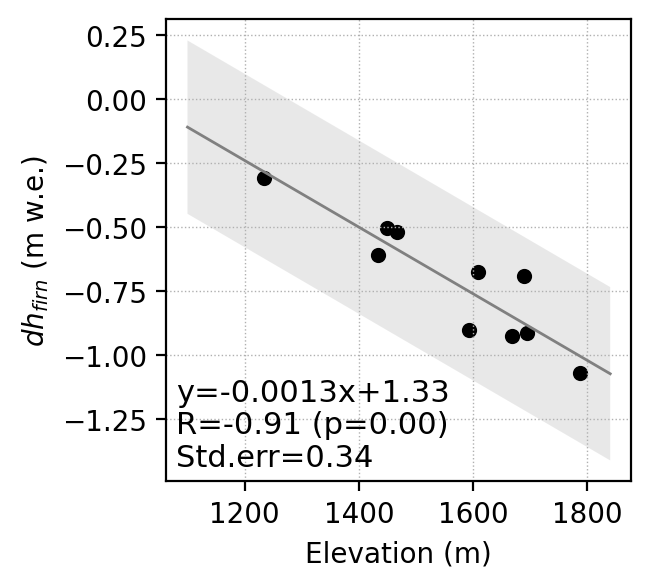

In [229]:
xh = []
xf = []

for p in keyList:
    df0 = dict_insitu2[p]
    df0 = df0[df0['year'] >= 2005].reset_index(drop = True)
    x0 = df0['x'].mean()
    y0 = df0['y'].mean()
    df0['dh_is2'] = np.nan
    idx = np.where((abs(xx-x0) < th) & (abs(yy-y0) < th))

    rho = df0['rho'].values
    rho[np.isnan(rho)] = 500
    ba_ann = np.nanmean(df0['ba_str'].values)
    ba_ann_pre = df0['ba_str'].values * np.nan
    ba_ann_pre[2:] = df0['ba_str'].values[:-2]

    if ba_ann > 0:
        xf.append(-ba_ann*1000 * (1/550 - 1/900)*0.5)
        xh.append(df0['h'].mean())

fig, ax = plt.subplots(figsize = (3,3), dpi = 200)

reg = stats.linregress(xh, xf)
a = reg.slope
b = reg.intercept
r = reg.rvalue
p = reg.pvalue
std_err = reg.intercept_stderr
print(a, b, r, p, std_err)

ax.scatter(xh, xf, color = "k", s= 20, marker = "o")

xs = np.arange(1100, 1850, 10)
ys = a*xs + b
ys[ys > 0] = np.nan
plt.plot(xs, ys, color = "gray", label = f"{year} (R={r:.2f}; p={p:.2f}; Std.err={std_err:.2f})", ls = "-", lw = 1)

plt.fill_between(xs, a*xs + b - std_err, a*xs + b + std_err, alpha = 0.5, zorder = 0, color = "lightgray", ec = "none")
    
plt.annotate(f"y={a:.4f}x+{b:.2f}", xy=(0.02,0.16), xycoords='axes fraction', fontsize=11, ha='left', va='bottom')
plt.annotate(f"R={r:.2f} (p={p:.2f})", xy=(0.02,0.09), xycoords='axes fraction', fontsize=11, ha='left', va='bottom')
plt.annotate(f"Std.err={std_err:.2f}", xy=(0.02,0.02), xycoords='axes fraction', fontsize=11, ha='left', va='bottom')
# plt.legend(fontsize = 8, loc = (1.05,0.0))
plt.xlabel("Elevation (m)")
plt.ylabel("$dh_{firn}$ (m)")
plt.grid(ls = ":", lw = 0.5)
    

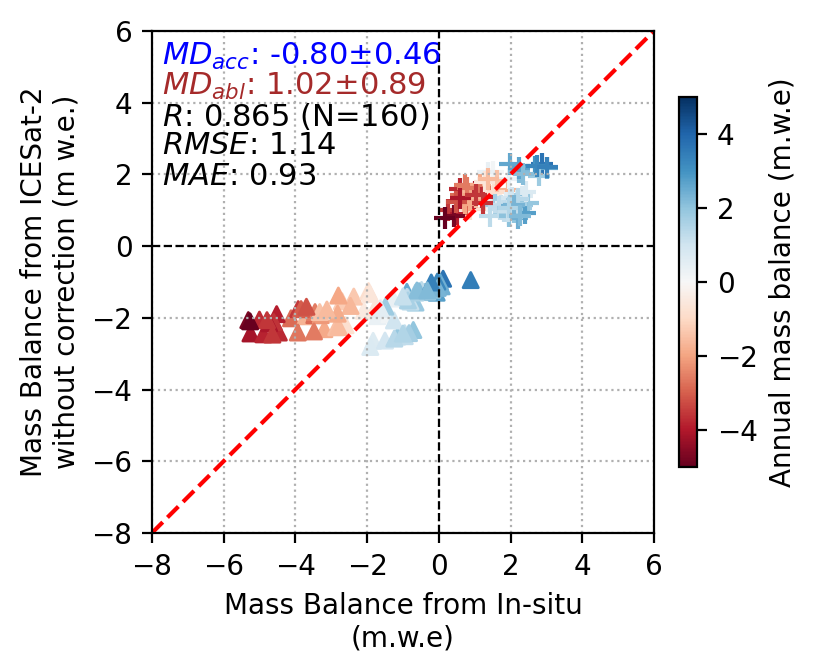

In [110]:
from sklearn.metrics import mean_squared_error as mse

plt.subplots(1,1, dpi = 200, figsize = (4,4))
xval = []
yval = []
flags = []
flags2 = []
names = []
times = []

y_field = 'dh_is2' #dh_is2, b_is2
for p in dict_insitu2.keys():
  # plt.errorbar(dict_insitu2[p]['b_fld'].values, dict_insitu2[p][y_field].values, dict_insitu2[p]['dh_std'], fmt ='.', markersize = 10,
  #              color = "gray", capsize=4, alpha = 0.5, zorder = 0)
  # plt.scatter(dict_insitu2[p]['b_fld'].values, dict_insitu2[p]['dh_is2'].values, s=50, c = dict_insitu2[p]['h'], vmin = 700, vmax = 1700, marker = "+")

  df = dict_insitu3[p] #.dropna()
  df = df[df['year'] >= 2019]

  month = np.array([m.month for m in df['d2']])
  year = np.array([m.year for m in df['d2']])
  flag = np.zeros(len(month)) # season flag
  flag2 = np.zeros(len(month))
  flag2[df['ba_fld'] > 0] = 1 # acc: 1; abl: 0

  idx_sum = (month > 8) & (month < 12)
  idx_win = (month > 2) & (month < 6)
  flag[idx_win] = 1

  rhos = df['rho'].values
  rhos[np.isnan(rhos)] = 475

  if y_field == 'dh_is2':
    zval = rhos/1000*(df[y_field])
  else:
    zval = df[y_field]

  # print(zval[idx_win])

  # winter mass balance
  plt.scatter(df['b_fld'][idx_win].values, zval[idx_win].values, s=60, c = df['ba_str'][idx_win],
              vmin = -5, vmax = 5, cmap= "RdBu", marker = "+")

  # summer mass balance
  plt.scatter(df['b_fld'][idx_sum].values, zval[idx_sum].values, s=30, c = df['ba_str'][idx_sum],
              vmin = -5, vmax = 5, cmap= "RdBu", marker = "^")

  xval = np.append(xval, df['b_fld'].values)
  yval = np.append(yval, zval)
  flags = np.append(flags, flag)
  flags2 = np.append(flags2, flag2)
  names = np.append(names, np.repeat(np.array(p), len(zval)))
  times = np.append(times, year)

idx = (xval > -1000) & (yval > -1000)
rmse = mse(xval[idx], yval[idx]) ** 0.5
mae = np.nanmean(abs(yval[idx] - xval[idx]))
meacc = np.nanmean(yval[idx & (flags2 == 1)] - xval[idx & (flags2 == 1)])
meacc_std = np.nanstd(yval[idx & (flags2 == 1)] - xval[idx & (flags2 == 1)])
meabl = np.nanmean(yval[idx & (flags2 == 0)] - xval[idx & (flags2 == 0)])
meabl_std = np.nanstd(yval[idx & (flags2 == 0)] - xval[idx & (flags2 == 0)])
mbe = np.nanmean(yval[idx] - xval[idx])
r = np.corrcoef(xval[idx], yval[idx])[0][1]

rmse_win = mse(xval[idx & (flags == 1)], yval[idx & (flags == 1)]) ** 0.5
rmse_sum = mse(xval[idx & (flags == 0)], yval[idx & (flags == 0)]) ** 0.5
mbe_win = np.nanmean(yval[idx & (flags == 1)] - xval[idx & (flags == 1)])
mbe_sum = np.nanmean(yval[idx & (flags == 0)] - xval[idx & (flags == 0)])

plt.axis('scaled')
plt.axhline(0, color = "k", ls = "--", lw = 0.8)
plt.axvline(0, color = "k", ls = "--", lw = 0.8)

plt.grid(ls = ":")
xmin, xmax = plt.xlim(-8, 6)
plt.ylim(xmin, xmax)
plt.plot([xmin, xmax], [xmin, xmax], color = "r", ls = "--")
plt.xticks(np.arange(xmin, xmax+1, 2))
plt.yticks(np.arange(xmin, xmax+1, 2))

plt.xlabel("Mass Balance from In-situ\n(m.w.e)")

if y_field == 'dh_is2':
  plt.ylabel("Mass Balance from ICESat-2\nwithout correction (m w.e.)")
else:
  plt.ylabel("Mass Balance from ICESat-2\nwith correction (m w.e.)")

plt.annotate(f"$R$: {r:.3f} (N={len(xval[idx])})", xy=(0.02,0.86), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.annotate("$MAE$: " + f"{mae:.2f}", xy=(0.02,0.74), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.annotate(f"$RMSE$: {rmse:.2f}", xy=(0.02,0.80), xycoords='axes fraction', fontsize=11, ha='left', va='top')

plt.annotate("$MD_{acc}$"+f": {meacc:.2f}$\pm${meacc_std:.2f}", xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top', color = "b")
plt.annotate("$MD_{abl}$"+f": {meabl:.2f}$\pm${meabl_std:.2f}", xy=(0.02,0.92), xycoords='axes fraction', fontsize=11, ha='left', va='top', color = "brown")
plt.colorbar(label = "Annual mass balance (m.w.e)", shrink = 0.6, pad = 0.04)
plt.savefig(f"C:\\Users\\yoko2261\\OneDrive - UCB-O365\\Documents\\paper_submission\\Iceland_glacier\\In-situ_comparison_{y_field}_{res}.png", bbox_inches = "tight")

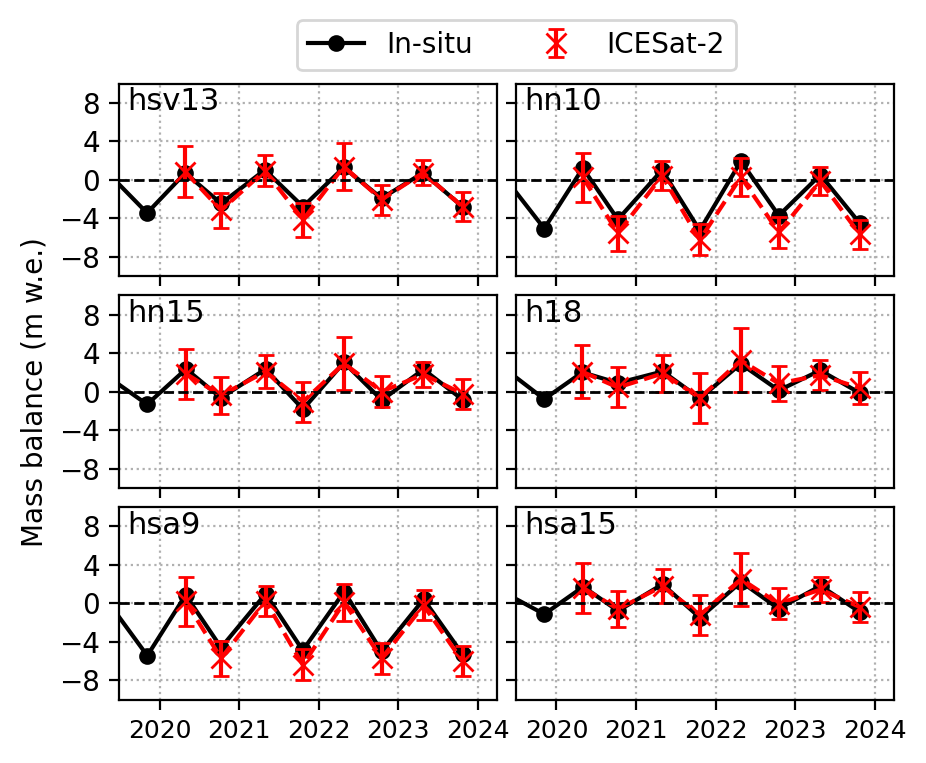

In [42]:
plotList = ['hsv13', 'hn15', 'hsa9', 'hn10', 'h18', 'hsa15']
#['hn14', 'hn16', 'h18', 'hsa13', 'hsa15', 'hsa11', 'hsa16', 'hsv15', 'hsa9']

N = len(plotList)
# fig, ax = plt.subplots(2,3, figsize = (8,3), dpi = 200, sharex = True, sharey= True)
fig, ax = plt.subplots(3,2, figsize = (5, 4), dpi = 200, sharex = True, sharey= True)
fig.subplots_adjust(wspace = 0.05, hspace = 0.1)

df_compare = pd.DataFrame()

k = 0

for n, site in enumerate(plotList[:]):

  i = n % ax.shape[0]
  j = n // ax.shape[0]

  df = dict_insitu3[site]

  ax[i,j].plot(df['d2'], df['b_fld'], color = "k", marker = "o", label = "In-situ", markersize = 5)

  df1 = dict_insitu3[site]
  y_field = 'b_is2'
  if len(df1) > 0:
    df1.loc[abs(df1['b_fld']) > 10, 'b_fld'] = np.nan
    ax[i,j].plot(df1['d2'], df1[y_field], color = "r", ls = "--")
    plotline = ax[i,j].errorbar(df1['d2'], df1[y_field], df1['dh_std'], fmt = 'x',
                                        markersize = 7, color = "r", capsize=3, label = "ICESat-2")

  ax[i,j].annotate(site, xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top')
  ax[i,j].set_ylim(-10, 10)
  ax[i,j].set_yticks(np.arange(-8, 10, 4))
  ax[i,j].grid(ls = ":")


  ax[i,j].axhline(0, color = "k", ls = "--", lw = 1)

  ax[i,j].set_xlim(datetime(2019, 7, 1), datetime(2024, 4, 1))
  # ax.fill(df2['date'], df2['h_balance'], color = "r")
  ax[i,j].set_xticks([datetime(2020, 1, 1), datetime(2021, 1, 1),  datetime(2022, 1, 1), datetime(2023, 1, 1), datetime(2024, 1, 1)],
   [2020, 2021, 2022, 2023, 2024], fontsize = 9, rotation = 0)

  if j == 0 and i == 1:
    ax[i,j].set_ylabel("Mass balance (m w.e.)")

ax[0,1].legend(fontsize = 10, ncol = 2, bbox_to_anchor = (0., 1.2), loc = "center")

plt.savefig(f"C:\\Users\\yoko2261\\OneDrive - UCB-O365\\Documents\\paper_submission\\Iceland_glacier\\In-situ_comparison_time_series_{res}.png", bbox_inches = "tight")

# References
- https://slideruleearth.io/web/rtd/index.html
- https://slideruleearth.io/web/rtd/getting_started/Examples.html
- https://slideruleearth.io/web/rtd/user_guide/ICESat-2.html